# **Machine Learning Class Fall 2025 Assignment 2**

In this assignment, we will explore clustering, dimensionality reduction, convolutional neural networks (CNNs), and deep clustering. You will need to answer the bolded questions and fill in the missing code snippets (marked by TODO).

Make a copy of this notebook using File > Save a copy in Drive and edit it with your answers.

WARNING: Do not put your name or any other personal identification information in this notebook.

**Rules**
- Use only `numpy` and `matplotlib` unless otherwise specified in each question.  
- Fill in all `TODO` blocks. Answer bolded questions in this notebook.  
- This assignment may require GPU support for Q4. You may enable GPU via  
Runtime > Change runtime type > Python 3 + T4-GPU.  

**Submission**
- Please submit the completed .ipynb file to NTU COOL before the deadline (Deadline: 2025-10-31 23:59).  
- You have a total of two extra days available for late submissions across all assignments.  
  - If you want to use late days for an assignment, please send an email to ml-elsalab@googlegroups.com specifying the number of late days you intend to use (in units of days).  

**Grading**
- The first four questions (Q1–Q4) together account for 70 points.  


# **Question 1: Clustering**

This question introduces classical clustering algorithms, from **K-means** to **Gaussian Mixture Models (GMM)**, and explores their limitations on non-spherical datasets. You will also compare with more advanced clustering methods such as **Spectral Clustering, DBSCAN, and Hierarchical Clustering**.

**Grading**: This question is worth **15 points total**.


## **Part A — K-means initialization and convergence**

In this part, you will implement K-means clustering with two initialization methods:
- **Random initialization**
- **K-means++ initialization**

Then, you will compare their convergence behavior.

**Instructions**
- Implement K-means from scratch, supporting both random and K-means++ initialization.
- For each initialization method, run **n_init = 10** restarts with the same random seed.
- Report:
  - The number of iterations until convergence for each run.
  - The average number of iterations.
  - The fastest and slowest convergence among the 10 runs.
- Visualize the final clustering result and centroids.

**Scoring (3pts)**
- Correct implementation of **Random initialization** and **K-means++ initialization**.
- Both methods must produce **valid clustering results** (clusters are well separated and centroids are reasonable).
- The **average convergence iterations** of K-means++ must be **smaller than** that of random initialization.
- You must provide a **visualization** of the clustering results and centroids for both methods.




⚠️ **Do not modify this cell** — any changes will result in a score of **0** for your implementation of this problem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs


np.random.seed(42)

# Construct dataset: Three well-separated clusters
X, y_true = make_blobs(n_samples=[200, 200, 200],
                       centers=[(-5, -5), (0, 5), (5, -2)],
                       cluster_std=[0.8, 0.7, 0.6],
                       random_state=42)
def plot_ground_truth(X, y):
    colors = ['red', 'green', 'blue']
    plt.figure(figsize=(6,6))
    for i, color in enumerate(colors):
        plt.scatter(X[y==i,0], X[y==i,1], c=color, s=10, alpha=0.6, label=f"Cluster {i}")
    plt.title("Ground Truth Clusters (for reference only)")
    plt.legend()
    plt.show()

def plot_clusters(X, labels, centroids, title="Clusters"):
    # Plot points colored by `labels` and mark centroids as red X.
    plt.figure(figsize=(6,6))
    plt.scatter(X[:,0], X[:,1], c=labels, cmap='viridis', s=20, alpha=0.65)
    plt.scatter(centroids[:,0], centroids[:,1], c="red", marker="x", s=200, linewidths=3)
    plt.title(title)
    plt.show()


In [4]:
# Part A: K-means with multiple restarts (n_init)
# Implement K-means supporting random / kmeans++ init and n_init restarts.
# Compare convergence speed (iterations).

class KMeans:
    def __init__(self, n_clusters=3, max_iters=200, tol=1e-4,
                 init="random", n_init=10, random_state=146):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol
        self.init = init
        self.n_init = n_init
        self.random_state = random_state


    def _rand_state(self, i):
        return np.random.RandomState(self.random_state + i)

    def initialize_centroids(self, X, rng):
        n, d = X.shape
        if self.init == "random":
            # TODO: select self.n_clusters samples randomly from X as initial centroids
            idx = rng.choice(n, self.n_clusters, replace=False)
            centroids = X[idx].copy()

        elif self.init == "kmeans++":
            # TODO: implement K-means++ initialization
            # Hint:
            #   Step 1: randomly choose the first centroid
            #   Step 2: compute squared distance (D^2) to nearest chosen centroid
            #   Step 3: sample next centroid with probability proportional to D^2
            centroids = np.empty((self.n_clusters, d), dtype=X.dtype)
            # first centroid
            i0 = rng.randint(0, n)
            centroids[0] = X[i0]
            # subsequent centroids
            for k in range(1, self.n_clusters):
                # squared distance to nearest chosen centroid
                diff = X[:, None, :] - centroids[:k][None, :, :]
                d2 = np.sum(diff**2, axis=2)
                mind2 = np.min(d2, axis=1)
                probs = mind2 / np.sum(mind2)
                next_idx = rng.choice(n, p=probs)
                centroids[k] = X[next_idx]

        return centroids


    def compute_distances(self, X, centroids):
        # TODO: compute pairwise distances between each point and each centroid
        # return squared Euclidean distances (sqrt not needed for argmin)
        # shape: (n_samples, n_clusters)
        X2 = np.sum(X**2, axis=1, keepdims=True)
        C2 = np.sum(centroids**2, axis=1, keepdims=True).T
        d2 = X2 + C2 - 2.0 * X @ centroids.T
        np.maximum(d2, 0, out=d2)  # numeric safety
        return d2

    def assign_clusters(self, distances):
        # TODO: assign each point to the closest centroid index
        return np.argmin(distances, axis=1)

    def update_centroids(self, X, labels):
        # TODO: update centroids based on assigned points
        # Hint:
        #   Step 1: compute mean of points in each cluster
        #   Step 2: if a cluster is empty, randomly re-seed from X
        n, d = X.shape
        centroids = np.zeros((self.n_clusters, d), dtype=X.dtype)
        # deterministic fallback RNG for rare empty-cluster cases
        fallback_rng = np.random.RandomState(0)
        for k in range(self.n_clusters):
            mask = (labels == k)
            if np.any(mask):
                centroids[k] = X[mask].mean(axis=0)
            else:
                centroids[k] = X[fallback_rng.randint(0, n)]
        return centroids

    def inertia(self, X, centroids, labels):
        # TODO: implement inertia = sum of squared distances to assigned centroids
        diffs = X - centroids[labels]
        return float(np.sum(np.sum(diffs**2, axis=1)))

    def _single_fit(self, X, rng):
        # Run a single K-means run (one initialization).
        centroids = self.initialize_centroids(X, rng)
        n_iter = 0
        for it in range(self.max_iters):
            distances = self.compute_distances(X, centroids)
            labels = self.assign_clusters(distances)
            new_centroids = self.update_centroids(X, labels)
            n_iter = it + 1
            if np.allclose(centroids, new_centroids, atol=self.tol):
                break
            centroids = new_centroids
        inert = self.inertia(X, centroids, labels)
        return centroids, labels, inert, n_iter

    def fit(self, X):
        # Run n_init restarts; keep best by lowest inertia.
        best = None
        iters = []
        iners = []
        for i in range(self.n_init):
            rng = self._rand_state(i)
            c, l, inert, niter = self._single_fit(X, rng)
            iters.append(niter)
            iners.append(inert)
            if (best is None) or (inert < best[2]):
                best = (c, l, inert, niter)
        self.centroids, self.labels_, self.inertia_, self.n_iter_best_ = best
        self.n_iter_all_ = iters
        self.inertia_all_ = iners
        self.n_iter_mean_ = float(np.mean(iters))
        return self



⚠️ **Do not modify this cell** — any changes will result in a score of **0** for your implementation of this problem.

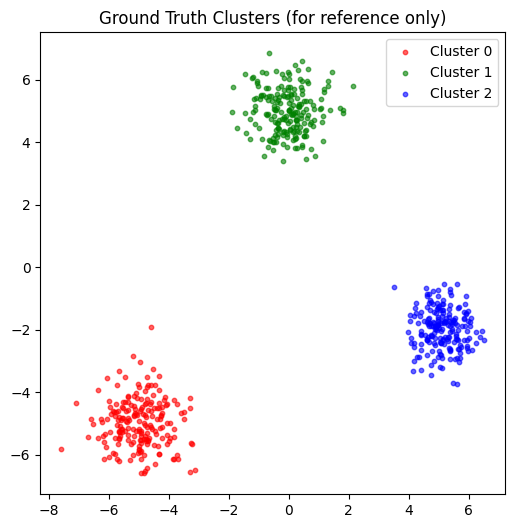

[random]
  Iterations (all runs): [2, 19, 2, 13, 6, 3, 5, 9, 2, 4]
  Iterations (mean): 6.50
  Fastest run (min iter): 2
  Slowest run (max iter): 19


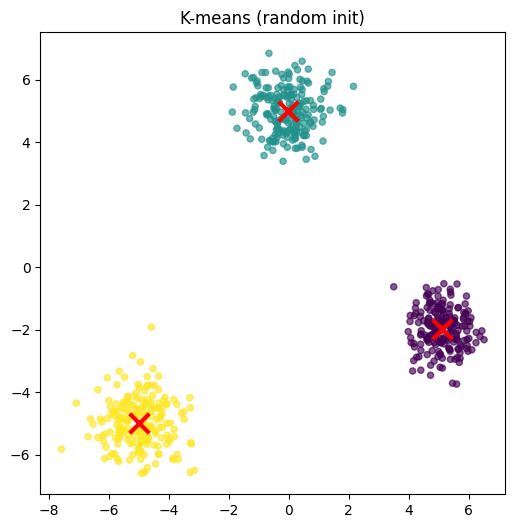

[kmeans++]
  Iterations (all runs): [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
  Iterations (mean): 2.00
  Fastest run (min iter): 2
  Slowest run (max iter): 2


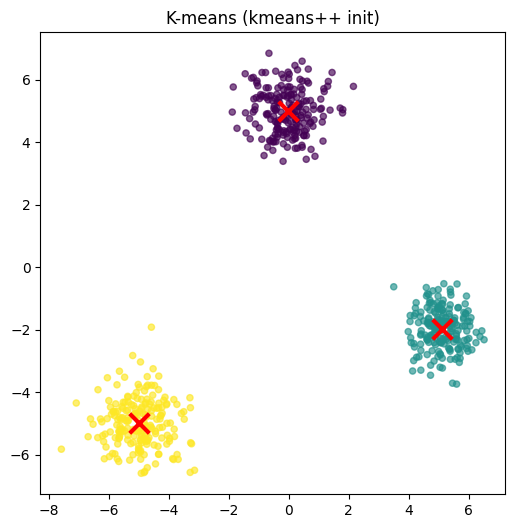

In [5]:
def run_and_report(X, init, n_init=10, random_state=146):
    km = KMeans(n_clusters=3, init=init, n_init=n_init, max_iters=200, tol=1e-4, random_state=random_state)
    km.fit(X)
    print(f"[{init}]")
    print(f"  Iterations (all runs): {km.n_iter_all_}")
    print(f"  Iterations (mean): {km.n_iter_mean_:.2f}")
    print(f"  Fastest run (min iter): {min(km.n_iter_all_)}")
    print(f"  Slowest run (max iter): {max(km.n_iter_all_)}")
    plot_clusters(X, km.labels_, km.centroids, f"K-means ({init} init)")


plot_ground_truth(X, y_true)

# Run both inits with same n_init and same random_state
run_and_report(X, init="random",   n_init=10, random_state=146)
run_and_report(X, init="kmeans++", n_init=10, random_state=146)


**Failure case — K-means on concentric Gaussians**
- Apply your K-means implementation to the provided **concentric Gaussian dataset**.
- You do not need to implement anything new. Simply run your existing code and observe the result.

⚠️ You should observe that K-means fails on this dataset.  
Even with K-means++ initialization, both clusters share the same mean, so centroids collapse and the algorithm cannot separate the inner and outer rings.  
This demonstrates the limitation of K-means: it only partitions space by **Euclidean distance to centroids**, and cannot handle clusters with the same mean but different covariances.  
In the next part, we will see how Gaussian Mixture Models (GMMs) with EM can resolve this issue.


K-means (k++ init) on concentric Gaussians — ARI: -0.023, NMI: 0.080
Iterations (all runs): [10, 13, 13, 40, 26, 13, 5, 16, 13, 26] | mean: 17.50


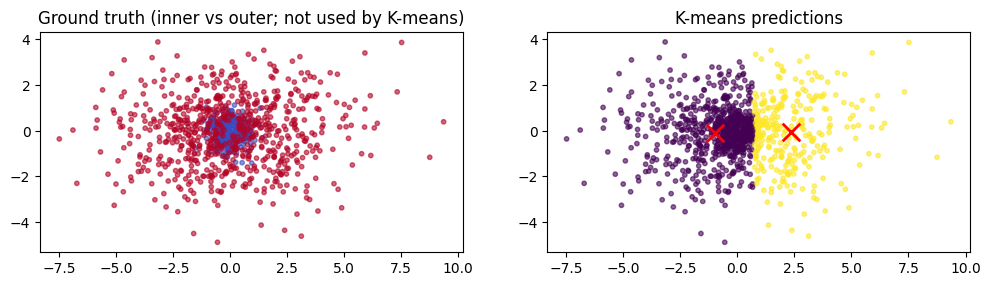

In [6]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

rng_fail = np.random.RandomState(7)

mu = np.array([0.0, 0.0])
Sigma_inner = np.diag([0.25, 0.25])
Sigma_outer = np.diag([6.25, 2.25])

X_inner = rng_fail.multivariate_normal(mu, Sigma_inner, size=300)
X_outer = rng_fail.multivariate_normal(mu, Sigma_outer, size=700)

X_fail = np.vstack([X_inner, X_outer])
y_true_fail = np.array([0]*300 + [1]*700)  # 0=inner, 1=outer

def plot_gt_vs_pred(X, y_true, y_pred, centroids):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].scatter(X[:,0], X[:,1], c=y_true, cmap='coolwarm', s=10, alpha=0.6)
    axes[0].set_title("Ground truth (inner vs outer; not used by K-means)")
    sc = axes[1].scatter(X[:,0], X[:,1], c=y_pred, cmap='viridis', s=10, alpha=0.6)
    axes[1].scatter(centroids[:,0], centroids[:,1], c='red', marker='x', s=160, linewidths=2)
    axes[1].set_title("K-means predictions")
    for ax in axes:
        ax.set_aspect('equal', adjustable='box')
    plt.show()

km_fail = KMeans(n_clusters=2, init="kmeans++", n_init=10, max_iters=200, tol=1e-4, random_state=146)
km_fail.fit(X_fail)

ari = adjusted_rand_score(y_true_fail, km_fail.labels_)
nmi = normalized_mutual_info_score(y_true_fail, km_fail.labels_)
print(f"K-means (k++ init) on concentric Gaussians — ARI: {ari:.3f}, NMI: {nmi:.3f}")
print(f"Iterations (all runs): {km_fail.n_iter_all_} | mean: {km_fail.n_iter_mean_:.2f}")

plot_gt_vs_pred(X_fail, y_true_fail, km_fail.labels_, km_fail.centroids)



## **Part B — Gaussian Mixture Model (GMM) with EM**

In this part, you will implement the **Expectation-Maximization (EM)** algorithm for a Gaussian Mixture Model (GMM), and compare it against K-means on the concentric Gaussian dataset where K-means fails.

**Instructions**
- Implement GMM from scratch with EM:
  - Initialize mixture weights, means, and covariance matrices.
  - **E-step**: compute responsibilities (posterior probabilities).
  - **M-step**: update parameters ($\pi_k, \mu_k, \Sigma_k$).
  - Compute log-likelihood at each iteration; stop when the improvement < tolerance or when max iterations reached.
- Run your GMM on the provided concentric Gaussian dataset.
- Visualize the clustering result:
  - Scatter plot with cluster assignments.
  - Overlay Gaussian ellipses from the learned covariances.
- Compare with K-means (from Part A):
  - Report ARI/NMI for both methods.
  - Plot log-likelihood curve for GMM to show monotonic increase.

**Scoring (4pts)**
- Correct implementation of **E-step** and **M-step**.
- Log-likelihood increases monotonically until convergence.
- Visualization of both **clusters** and **Gaussian ellipses**.
- Comparison with K-means clearly shows that **GMM succeeds** where K-means fails.


In [7]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import numpy.linalg as LA
from matplotlib.patches import Ellipse
np.random.seed(7)

mu = np.array([0.0, 0.0])
Sigma_inner = np.diag([0.25, 0.25])
Sigma_outer = np.diag([6.25, 2.25])

X_inner = np.random.multivariate_normal(mu, Sigma_inner, size=300)
X_outer = np.random.multivariate_normal(mu, Sigma_outer, size=700)

X_b = np.vstack([X_inner, X_outer])
y_true_b = np.array([0]*300 + [1]*700)  # 0=inner, 1=outer




In [10]:
# Part B: Gaussian Mixture Model (EM)
# Implement EM for GMM: initialize params, E-step (responsibilities), M-step (update), log-likelihood.

class GMM:
    def __init__(self, n_components=2, max_iters=200, tol=1e-4, reg_covar=1e-6, random_state=0):
        self.K = n_components
        self.max_iters = max_iters
        self.tol = tol
        self.reg_covar = reg_covar
        self.random_state = np.random.RandomState(random_state)


    def _initialize_params(self, X):
        N, D = X.shape
        # random responsibilities to seed means by soft assignment
        r = self.random_state.rand(N, self.K)
        r /= r.sum(axis=1, keepdims=True)
        Nk = r.sum(axis=0) + 1e-12
        self.pi_ = Nk / N
        self.means_ = (r.T @ X) / Nk[:, None]
        self.covariances_ = np.zeros((self.K, D, D))
        for k in range(self.K):
            Xc = X - self.means_[k]
            Sk = (r[:, [k]] * Xc).T @ Xc / Nk[k]
            Sk.flat[::D+1] += self.reg_covar  # regularize diagonal
            self.covariances_[k] = Sk

    def _gaussian_pdf(self, X, mean, cov):
        # TODO: Compute multivariate normal pdf N(X | mean, cov) for all rows in X
        # Hint: use formula with determinant and inverse of covariance
        N, D = X.shape
        # numerical safety
        cov = cov.copy()
        cov.flat[::D+1] += 0.0
        inv = LA.inv(cov)
        det = LA.det(cov)
        Xc = X - mean
        # Mahalanobis distances squared
        m2 = np.einsum('ni,ij,nj->n', Xc, inv, Xc)
        norm = np.sqrt(((2.0 * np.pi) ** D) * det)
        return np.exp(-0.5 * m2) / (norm + 1e-300)


    def _e_step(self, X):
        # TODO: Compute responsibilities gamma_{ik} ∝ pi_k * N(x_i | mu_k, Sigma_k), row-normalized
        N = X.shape[0]
        resp = np.zeros((N, self.K))
        for k in range(self.K):
            resp[:, k] = self.pi_[k] * self._gaussian_pdf(X, self.means_[k], self.covariances_[k])
        denom = resp.sum(axis=1, keepdims=True) + 1e-300
        resp /= denom
        return resp

    def _m_step(self, X, gamma):
        # TODO: Update pi_k, mu_k, Sigma_k using responsibilities
        N, D = X.shape
        Nk = gamma.sum(axis=0) + 1e-12
        self.pi_ = Nk / N
        self.means_ = (gamma.T @ X) / Nk[:, None]
        self.covariances_ = np.zeros((self.K, D, D))
        for k in range(self.K):
            Xc = X - self.means_[k]
            Sk = (gamma[:, [k]] * Xc).T @ Xc / Nk[k]
            Sk.flat[::D+1] += self.reg_covar
            self.covariances_[k] = Sk

    def _log_likelihood(self, X):
        # TODO: Compute total log-likelihood: sum_i log( sum_k pi_k * N(x_i | mu_k, Sigma_k) )
        N = X.shape[0]
        vals = np.zeros((N, self.K))
        for k in range(self.K):
            vals[:, k] = self.pi_[k] * self._gaussian_pdf(X, self.means_[k], self.covariances_[k])
        s = vals.sum(axis=1) + 1e-300
        return float(np.sum(np.log(s)))

    def fit(self, X):
        self._initialize_params(X)
        ll = []
        prev = -np.inf
        for _ in range(self.max_iters):
            gamma = self._e_step(X)
            self._m_step(X, gamma)
            cur = self._log_likelihood(X)
            ll.append(cur)
            if cur - prev < self.tol:
                break
            prev = cur
        self.resp_ = gamma
        self.labels_ = np.argmax(self.resp_, axis=1)
        self.loglik_ = ll
        return self

    def predict(self, X):
        gamma = self._e_step(X)
        return np.argmax(gamma, axis=1)



⚠️ **Do not modify this cell** — any changes will result in a score of **0** for your implementation of this problem.

GMM log-likelihood increases monotonically: True
GMM iterations: 47
GMM — ARI: 0.561, NMI: 0.460
K-means (k++ init) — ARI: -0.023, NMI: 0.080


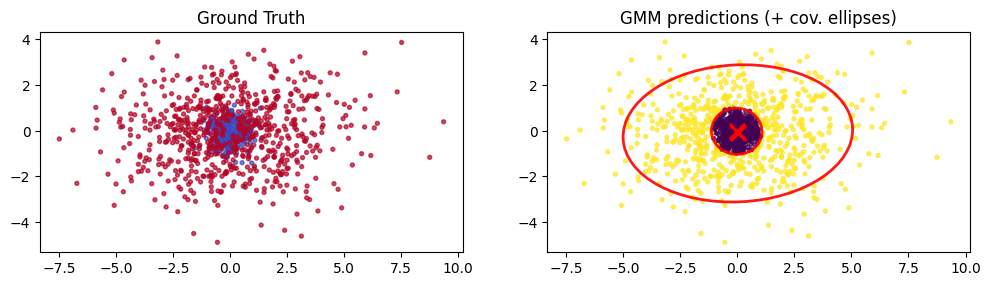

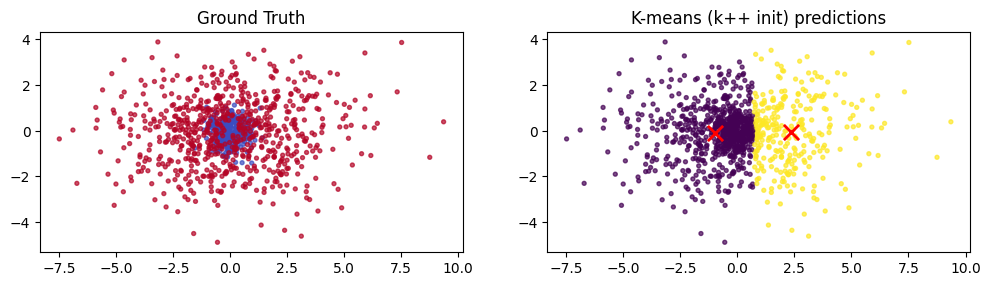

In [11]:

def plot_gmm_ellipses(ax, means, covs, color='red'):
    # Plot 95% covariance ellipses for 2D Gaussians.
    for m, S in zip(means, covs):
        w, v = LA.eigh(S)
        order = w.argsort()[::-1]
        w, v = w[order], v[:, order]
        angle = np.degrees(np.arctan2(v[1,0], v[0,0]))
        s = 2.0  # ~95% for Gaussian along principal axes
        ell = Ellipse(xy=m, width=2*s*np.sqrt(w[0]), height=2*s*np.sqrt(w[1]),
                      angle=angle, edgecolor=color, facecolor='none', lw=2, alpha=0.9)
        ax.add_patch(ell)

def side_by_side(X, y_true, y_pred, means=None, covs=None, title_pred="Predictions"):
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    axes[0].scatter(X[:,0], X[:,1], c=y_true, cmap='coolwarm', s=8, alpha=0.7)
    axes[0].set_title("Ground Truth")
    sc = axes[1].scatter(X[:,0], X[:,1], c=y_pred, cmap='viridis', s=8, alpha=0.7)
    if (means is not None) and (covs is not None):
        plot_gmm_ellipses(axes[1], means, covs, color='red')
        axes[1].scatter(means[:,0], means[:,1], c='red', marker='x', s=120, linewidths=2)
    axes[1].set_title(title_pred)
    for ax in axes:
        ax.set_aspect('equal', adjustable='box')
    plt.show()


gmm = GMM(n_components=2, max_iters=200, tol=1e-4, reg_covar=1e-6, random_state=0)
gmm.fit(X_b)

# Log-likelihood should be (near) monotonically increasing
is_monotone = all(x <= y + 1e-8 for x, y in zip(gmm.loglik_[:-1], gmm.loglik_[1:]))
print("GMM log-likelihood increases monotonically:", is_monotone)
print("GMM iterations:", len(gmm.loglik_))

# Metrics vs. ground truth
ari_gmm = adjusted_rand_score(y_true_b, gmm.labels_)
nmi_gmm = normalized_mutual_info_score(y_true_b, gmm.labels_)
print(f"GMM — ARI: {ari_gmm:.3f}, NMI: {nmi_gmm:.3f}")

# Compare with your Part A KMeans

km = KMeans(n_clusters=2, init="kmeans++", n_init=10, max_iters=200, tol=1e-4, random_state=146)
km.fit(X_b)
ari_km = adjusted_rand_score(y_true_b, km.labels_)
nmi_km = normalized_mutual_info_score(y_true_b, km.labels_)
print(f"K-means (k++ init) — ARI: {ari_km:.3f}, NMI: {nmi_km:.3f}")


side_by_side(
    X_b, y_true_b, gmm.labels_, means=gmm.means_, covs=gmm.covariances_,
    title_pred="GMM predictions (+ cov. ellipses)"
)

if not np.isnan(ari_km):
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    axes[0].scatter(X_b[:,0], X_b[:,1], c=y_true_b, cmap='coolwarm', s=8, alpha=0.7)
    axes[0].set_title("Ground Truth")
    axes[1].scatter(X_b[:,0], X_b[:,1], c=km.labels_, cmap='viridis', s=8, alpha=0.7)
    axes[1].scatter(km.centroids[:,0], km.centroids[:,1], c='red', marker='x', s=120, linewidths=2)
    axes[1].set_title("K-means (k++ init) predictions")
    for ax in axes:
        ax.set_aspect('equal', adjustable='box')
    plt.show()


**Failure case — GMM on non-convex data**
- Apply your GMM implementation to the **two moons dataset**.
- You do not need to implement anything new here. Just run your existing GMM code and observe the result.

⚠️ You should observe that GMM fails on this dataset, just like K-means.  
This is because both methods assume convex (elliptical) clusters.  
In the next part, we will implement **Spectral Clustering**, which can handle non-convex shapes such as the two moons.


GMM on two moons — ARI: 0.282, NMI: 0.367
Log-likelihood length: 34


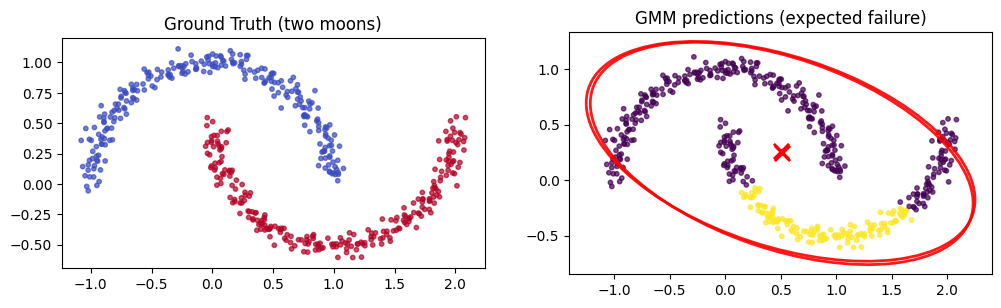

In [12]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.datasets import make_moons

X_fail_b, y_true_fail_b = make_moons(n_samples=500, noise=0.05, random_state=42)

# Fit your GMM (from Part B) on the two-moons failure set
gmm_fail = GMM(n_components=2, max_iters=200, tol=1e-4, reg_covar=1e-6, random_state=0)
gmm_fail.fit(X_fail_b)

ari = adjusted_rand_score(y_true_fail_b, gmm_fail.labels_)
nmi = normalized_mutual_info_score(y_true_fail_b, gmm_fail.labels_)
print(f"GMM on two moons — ARI: {ari:.3f}, NMI: {nmi:.3f}")
print("Log-likelihood length:", len(gmm_fail.loglik_))

# Side-by-side: Ground Truth vs GMM predictions (with Gaussian ellipses overlay)
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].scatter(X_fail_b[:,0], X_fail_b[:,1], c=y_true_fail_b, cmap='coolwarm', s=10, alpha=0.7)
axes[0].set_title("Ground Truth (two moons)")
axes[1].scatter(X_fail_b[:,0], X_fail_b[:,1], c=gmm_fail.labels_, cmap='viridis', s=10, alpha=0.7)
axes[1].set_title("GMM predictions (expected failure)")



plot_gmm_ellipses(axes[1], gmm_fail.means_, gmm_fail.covariances_, color='red')
axes[1].scatter(gmm_fail.means_[:,0], gmm_fail.means_[:,1], c='red', marker='x', s=120, linewidths=2)


for ax in axes:
    ax.set_aspect('equal', adjustable='box')
plt.show()





## **Part C — Beyond K-means/GMM: Non-convex clustering**

In this part, we will revisit the **two moons dataset**, where both K-means and GMM fail.  
You will implement two clustering methods that can successfully separate the moons:

### Part C1 — Spectral Clustering (from scratch)
- Construct a similarity graph using the RBF kernel.  
- Build the unnormalized Laplacian $L = D - W$, where $D$ is the degree matrix and $W$ is the similarity matrix.  
- Compute the first $k$ eigenvectors (corresponding to the smallest eigenvalues).  
- Normalize the eigenvectors row-wise and apply K-means to obtain final cluster assignments.  
- Visualize the clustering results.  

### Part C2 — DBSCAN (from scratch, brute-force version)
- Implement DBSCAN using $\epsilon$-neighborhood and $min\_samples$:  
  - Label points as core, border, or noise.  
  - Expand clusters from core points using BFS/DFS.  
- Apply your DBSCAN implementation to the two moons dataset.  
- Visualize the clustering results, showing clusters and noise points.  

**Scoring (4pts)**
- Correct implementation of Spectral Clustering and DBSCAN.  
- Both methods must achieve **ARI, NMI ≫ K-means/GMM** on the two moons dataset.  
- Clear visualizations are required for both methods.  


In [13]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Two-moons dataset
X_c, y_true_c = make_moons(n_samples=500, noise=0.05, random_state=42)

def plot_clusters(X, labels, title="Clusters"):
    plt.figure(figsize=(6,6))
    plt.scatter(X[:,0], X[:,1], c=labels, cmap='viridis', s=10, alpha=0.8)
    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()



In [14]:
# Part C1: Spectral Clustering
# Build similarity W (RBF), Laplacian L, smallest-k eigenvectors, row-normalize, then K-means.

class SpectralClustering:
    def __init__(self, n_clusters=2, sigma=None, random_state=0):
        self.k = n_clusters
        self.sigma = sigma
        self.random_state = random_state

    def _pairwise_sq_dists(self, X):
        # TODO: Compute pairwise squared Euclidean distances (n x n)
        X2 = np.sum(X**2, axis=1, keepdims=True)
        D2 = X2 + X2.T - 2.0 * (X @ X.T)
        np.maximum(D2, 0, out=D2)
        return D2

    def _rbf_similarity(self, D2, sigma):
        # TODO: Convert squared distances to RBF similarities: W_ij = exp(-D2_ij / (2*sigma^2))
        W = np.exp(-D2 / (2.0 * (sigma**2)))
        np.fill_diagonal(W, 0.0)
        return W

    def fit(self, X):
        n = X.shape[0]
        D2 = self._pairwise_sq_dists(X)
        self.sigma_ = float(self.sigma)

        # Similarity and Laplacian
        W = self._rbf_similarity(D2, self.sigma_)
        d = np.sum(W, axis=1)
        L = np.diag(d) - W

        # TODO: Compute eigenpairs and take eigenvectors of the k smallest eigenvalues
        evals, evecs = LA.eigh(L)
        Y = evecs[:, :self.k]

        # TODO: Normalize each row to unit length (avoid divide by zero)
        norms = np.linalg.norm(Y, axis=1, keepdims=True) + 1e-12
        Y = Y / norms

        km = KMeans(n_clusters=self.k, init="kmeans++", n_init=10, random_state=self.random_state)
        km.fit(Y)
        self.labels_ = km.labels_
        self.embedding_ = Y
        self.W_ = W
        self.L_ = L
        return self

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_


# Part C2: DBSCAN
# ε-neighborhood + min_samples; BFS expansion; label noise as -1.

class DBSCAN:
    def __init__(self, eps=0.2, min_samples=5):
        self.eps = float(eps)
        self.min_samples = int(min_samples)

    def _region_query(self, X, i):
        # TODO: Return indices of points within eps of X[i]
        d = np.linalg.norm(X - X[i], axis=1)
        return np.where(d <= self.eps)[0]

    def fit(self, X):
        n = X.shape[0]
        labels = -np.ones(n, dtype=int)  # -1 = noise by default
        visited = np.zeros(n, dtype=bool)
        cluster_id = 0

        for i in range(n):
            if visited[i]:
                continue
            visited[i] = True
            neighbors = self._region_query(X, i)

            if len(neighbors) < self.min_samples:
                labels[i] = -1  # noise
            else:
                # TODO: Expand a new cluster from core point i using BFS/DFS
                # Hint: repeatedly add neighbors of core points; border points join but don't expand
                # expand new cluster
                labels[i] = cluster_id
                seeds = list(neighbors.tolist())
                j = 0
                while j < len(seeds):
                    p = seeds[j]
                    if not visited[p]:
                        visited[p] = True
                        nbrs_p = self._region_query(X, p)
                        if len(nbrs_p) >= self.min_samples:  # core point
                            # add new neighbors not already in seeds
                            for q in nbrs_p:
                                if q not in seeds:
                                    seeds.append(q)
                    if labels[p] == -1:
                        labels[p] = cluster_id  # previously noise -> border
                    if labels[p] == -1 or labels[p] == cluster_id:
                        labels[p] = cluster_id
                    j += 1
                cluster_id += 1

        self.labels_ = labels
        self.n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        return self

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_


⚠️ **Restriction**: In the following cell, you are only allowed to **change the value of `sigma`**.  
Any other modifications will result in a score of **0** for this problem.  


=== Spectral Clustering on two moons ===
Spectral — ARI: 1.000, NMI: 1.000


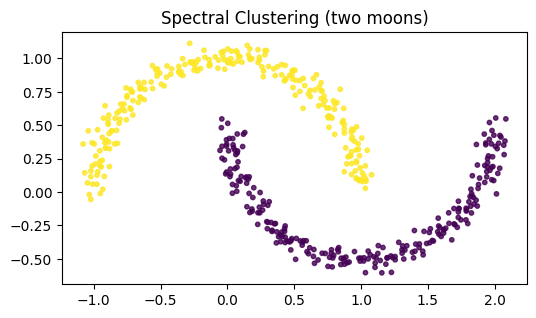

=== DBSCAN on two moons ===
DBSCAN — ARI: 1.000, NMI: 1.000 (labels may include -1 for noise)


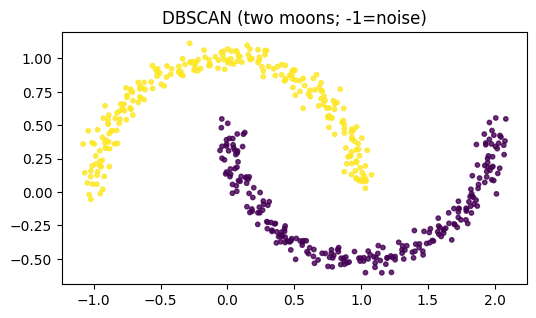

In [15]:
print("=== Spectral Clustering on two moons ===")

sigma = 0.2   # TODO: you can only adjust this value
spec = SpectralClustering(n_clusters=2, sigma=sigma, random_state=0)
y_spec = spec.fit_predict(X_c)
ari_s = adjusted_rand_score(y_true_c, y_spec)
nmi_s = normalized_mutual_info_score(y_true_c, y_spec)
print(f"Spectral — ARI: {ari_s:.3f}, NMI: {nmi_s:.3f}")
plot_clusters(X_c, y_spec, "Spectral Clustering (two moons)")

print("=== DBSCAN on two moons ===")
dbs = DBSCAN(eps=0.25, min_samples=5)
y_dbs = dbs.fit_predict(X_c)
ari_d = adjusted_rand_score(y_true_c, y_dbs)
nmi_d = normalized_mutual_info_score(y_true_c, y_dbs)
print(f"DBSCAN — ARI: {ari_d:.3f}, NMI: {nmi_d:.3f} (labels may include -1 for noise)")
plot_clusters(X_c, y_dbs, "DBSCAN (two moons; -1=noise)")


### Question

**1. (1 point)**  
Why does K-means fail on concentric Gaussian data?

**Answer:**

K-means partitions space by **Euclidean distance to centroids** (linear Voronoi cells) and assumes roughly spherical, mean-separated clusters. In concentric Gaussians the components **share the same mean**, so centroids collapse toward the center and no linear distance boundary can separate the inner ring from the outer ring.

---

**2. (1 point)**  
What advantage does GMM have over K-means that allows it to solve concentric Gaussians?  

**Answer:**  

A GMM models each cluster as a **full Gaussian** with its own covariance and uses **soft probabilistic assignments (EM)**. It can fit one component with a small covariance (inner ring) and another with a large covariance (outer ring), separating clusters by variance/covariance, not just by distance to a centroid.

---

**3. (1 point)**  
In Spectral Clustering, what is the effect of the parameter $\sigma$ in the RBF similarity function?  

**Answer:**  

𝜎 sets the scale of locality in the graph:

* **Small** 𝜎: only very nearby points are linked → sparse 𝑊, preserves fine non-convex structure but can fragment clusters/noisy.

* **Large** 𝜎: many points are linked → dense
𝑊, smoother but can **merge** distinct clusters.

---

**4. (1 point)**  
In DBSCAN, what happens to points that do not belong to any dense region?  

**Answer:**  

They are labeled as **noise/outliers** (typically −1) and left unassigned to any cluster (unless later found density-reachable from a core point).

---



# **Question 2: Dimensionality Reduction**

This question introduces classical **dimensionality reduction algorithms**, from **Principal Component Analysis (PCA)** to **Independent Component Analysis (ICA)**, and demonstrates how these methods can be applied to visualization and downstream tasks.  
You will also use **t-SNE** for non-linear dimensionality reduction and compare the embeddings with PCA.

In the final part, you will simulate a real-world scenario where **labels are not available**, and explore how dimensionality reduction combined with clustering can still produce useful pseudo-labels for classification.

**Grading**: This question is worth **20 points total**.


## **Part A — Principal Component Analysis (PCA, from scratch)**

In this part, you will implement **PCA** from scratch using NumPy.  
Your implementation should compute the covariance matrix of the dataset, perform eigen-decomposition, and use the top eigenvectors to form a lower-dimensional projection.  

**Instructions**
- Standardize the dataset (zero mean, unit variance).
- Compute the covariance matrix.
- Perform eigen-decomposition to obtain eigenvalues and eigenvectors.
- Sort eigenvalues in descending order and select the top $k$ eigenvectors.
- Project the data into $k$-dimensional space.
- Visualize the dataset in 2D using your PCA implementation.

**Scoring (5pts)**
- Correct computation of covariance matrix and eigen-decomposition.  
- Correct sorting and projection into 2D (shape must be (n_samples, 2)).  
- Visualization must be shown using `plot_2d_projection`.  
- Your implementation must not use `sklearn.decomposition.PCA`.  
- The explained variance ratio of your PCA result must differ from the sklearn reference by less than 0.05.  



In [16]:
from sklearn.datasets import load_digits

# Dataset: Digits (64-dim features, 10 classes)
digits = load_digits()
X = digits.data
y = digits.target

print("Data shape:", X.shape)
print("Labels shape:", y.shape)



Data shape: (1797, 64)
Labels shape: (1797,)


In [19]:
# Part A: PCA implementation

class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components_ = None
        self.mean_ = None

    def fit(self, X):
        # TODO: Center the data (subtract mean)
        X = np.asarray(X)
        self.mean_ = X.mean(axis=0)
        Xc = X - self.mean_

        # TODO: Compute covariance matrix (d x d)
        C = (Xc.T @ Xc) / (Xc.shape[0] - 1)

        # TODO: Eigen-decomposition of covariance matrix
        vals, vecs = np.linalg.eigh(C)

        # TODO: Sort eigenvalues/eigenvectors in descending order
        order = np.argsort(vals)[::-1]

        # TODO: Select the top-k eigenvectors
        self.components_ = vecs[:, order[:self.n_components]]
        return self

    def transform(self, X):
        # TODO: Project data into lower dimension using selected eigenvectors
        X = np.asarray(X)
        Xc = X - self.mean_
        return Xc @ self.components_

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)



⚠️ **Do not modify this cell** — any changes will result in a score of **0** for your implementation of this problem.

⚠️ Reminder: The explained variance ratio of your PCA result must differ from the sklearn reference by less than 0.05.  


Projected shape: (1797, 2)


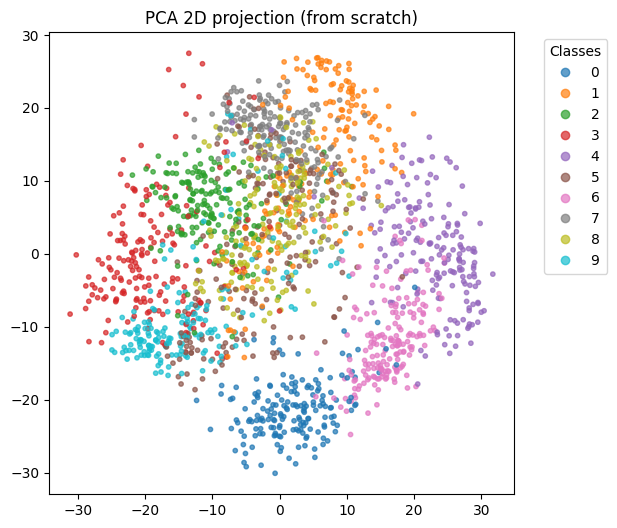

Explained variance ratio (sklearn reference): 0.2851
Explained variance ratio (your PCA)       : 0.2851
PCA grading check: PASSED


In [20]:
def plot_2d_projection(Z, labels, title="2D projection"):
    plt.figure(figsize=(6,6))
    scatter = plt.scatter(Z[:,0], Z[:,1], c=labels, cmap="tab10", s=10, alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title)
    plt.show()

pca = PCA(n_components=2)
X_proj = pca.fit_transform(X)

print("Projected shape:", X_proj.shape)


plot_2d_projection(X_proj, y, title="PCA 2D projection (from scratch)")

# grading for PCA Part A
# Purpose: verify your PCA preserves the correct variance.


import sys
if 'sklearn.decomposition' in sys.modules:
    raise AssertionError(
        "Detected 'sklearn.decomposition' was imported earlier. "
        "Do NOT import or use sklearn.decomposition in your implementation."
    )


pca_student = PCA(n_components=2)
X_proj_student = pca_student.fit_transform(X)
I = pca_student.components_.T @ pca_student.components_

# NOTE: Students MUST NOT use sklearn.decomposition.PCA in your implementation.
#       This cell may import sklearn internally for grading reference.
from sklearn.decomposition import PCA as SkPCA


pca_ref = SkPCA(n_components=2).fit(X)
evr_ref = float(np.sum(pca_ref.explained_variance_ratio_))

evr_student = float(np.sum(np.var(X_proj_student, axis=0, ddof=1)) / np.var(X, axis=0, ddof=1).sum())

print("Explained variance ratio (sklearn reference):", round(evr_ref, 4))
print("Explained variance ratio (your PCA)       :", round(evr_student, 4))

assert abs(evr_ref - evr_student) < 0.05, "Your PCA does not capture the correct variance."
print("PCA grading check: PASSED")




## **Part B — Independent Component Analysis (ICA)**

In this part, you will implement **FastICA from scratch** to perform **blind source separation**.  
We provide you with a dataset of two audio signals mixed linearly into two observed channels. Your task is to recover the original sources.  

Steps:
1. Center and whiten the observed signals.  
2. Implement the FastICA algorithm using the fixed-point iteration:  

   - Initialize a random unmixing vector $w$.  
   - Iteratively update:  
     $
     w \leftarrow \mathbb{E}[x\, g(w^\top x)] - \mathbb{E}[g'(w^\top x)]\, w
     $  
     where $g(u) = \tanh(u)$, $g'(u) = 1 - \tanh^2(u)$.  
   - Normalize $w$ after each update.  
   - Apply decorrelation to ensure orthogonality between multiple components.  

3. Recover the estimated sources $S = X W^\top$.  
4. Compare the recovered signals with the ground truth (waveform plots).  

⚠️ You must **not** use `sklearn.decomposition.FastICA`.  

---

**Scoring (5pts)**
- Correct whitening of observed signals.  
- Correct implementation of the FastICA update rule (with decorrelation).  
- Successfully recover the original sources (signals visibly separated when plotted).  
- The correlation coefficient between recovered sources and ground truth must exceed **0.9** (up to permutation and sign flip).  


In [21]:
rng = np.random.RandomState(42)

# Create two source signals (length T)
T = 5000
t = np.linspace(0, 8*np.pi, T)

# Source 1: sine wave with varying frequency
s1 = np.sin(2.0 * t) * (1.0 + 0.5 * np.sin(0.5 * t))

# Source 2: square-ish wave (sign of sine) plus small noise
s2 = np.sign(np.sin(1.0 * t))
s2 = s2 + 0.05 * rng.randn(T)

S_true = np.vstack([s1, s2]).T  # shape (T, 2)

A = np.array([[1.0, 0.5],[0.4, 1.2]])
X_mixed = S_true @ A.T



In [22]:
# Part B: FastICA implementation (from scratch)

class ICA:
    # Simple FastICA implementation (fixed-point algorithm) for 2D signals.

    def __init__(self, n_components=2, max_iters=1000, tol=1e-6, random_state=0):
        self.n_components = n_components
        self.max_iters = int(max_iters)
        self.tol = float(tol)
        self.random_state = np.random.RandomState(random_state)
        # learned parameters
        self.whitening_ = None
        self.dewhitening_ = None
        self.W_ = None  # unmixing matrix


    def _center(self, X):
        # TODO: subtract mean from X and store mean for later
        # Hint: mean along axis 0
        self.mean_ = X.mean(axis=0)
        return X - self.mean_

    def _whiten(self, X):
        # TODO: whiten X (zero-mean assumed). Return X_white, and set whitening_/dewhitening_.
        # Hint: use eigen-decomposition of covariance or SVD.
        C = np.cov(X, rowvar=False)
        vals, vecs = np.linalg.eigh(C)
        order = np.argsort(vals)[::-1]
        vals, vecs = vals[order], vecs[:, order]
        eps = 1e-12
        D_inv_sqrt = np.diag(1.0 / np.sqrt(vals + eps))
        D_sqrt = np.diag(np.sqrt(vals + eps))
        # Whitening matrix Ww so that X_white = X @ Ww^T
        self.whitening_ = D_inv_sqrt @ vecs.T
        self.dewhitening_ = vecs @ D_sqrt @ vecs.T
        X_white = X @ self.whitening_.T
        return X_white

    def _g(self, u):
        # non-linearity g(u) = tanh(u)
        return np.tanh(u)

    def _g_prime(self, u):
        # derivative g'(u) = 1 - tanh(u)^2
        return 1.0 - np.tanh(u)**2


    # Core algorithm
    def fit(self, X):
        # Fit the ICA model to mixed signals X (shape [n_samples, n_features]).
        X = np.asarray(X)
        N, D = X.shape
        assert D >= self.n_components, "n_components must be <= n_features"


        Xc = self._center(X)
        Xw = self._whiten(Xc)  # shape (N, D)
        W = np.zeros((self.n_components, self.n_components))
        for p in range(self.n_components):
            # TODO: initialize each w randomly (unit norm)
            w = self.random_state.randn(self.n_components)
            w /= (np.linalg.norm(w) + 1e-12)

            # fixed-point iteration for this component
            for it in range(self.max_iters):
                # TODO: compute w_new = E[x * g(w^T x)] - E[g'(w^T x)] * w
                # Hint: use matrix operations; Xw shape = (N, D)
                wx = Xw @ w
                g = self._g(wx)
                gp = self._g_prime(wx)
                # w_new = E[x * g(w^T x)] - E[g'(w^T x)] * w
                w_new = (Xw.T @ g) / N - gp.mean() * w

                # Decorrelate against previously found components (symmetric decorrelation)
                if p > 0:
                    w_new -= W[:p].T @ (W[:p] @ w_new)

                # Normalize
                w_new /= (np.linalg.norm(w_new) + 1e-12)

                # check convergence (absolute dot change)
                if np.abs(np.abs(np.dot(w, w_new)) - 1.0) < self.tol:
                    w = w_new
                    break
                w = w_new

            W[p, :self.n_components] = w

        # Final symmetric decorrelation of W (ensure orthonormal rows)
        # TODO: perform symmetric decorrelation: W <- (W W^T)^{-1/2} W
        B = W @ W.T
        vals, vecs = np.linalg.eigh(B)
        W = (vecs @ np.diag(1.0 / np.sqrt(vals + 1e-12)) @ vecs.T) @ W

        self.W_ = W
        return self

    def transform(self, X):
        # Apply the learned unmixing to X and return estimated sources S (shape N x n_components).
        X = np.asarray(X)
        Xc = X - getattr(self, "mean_", np.mean(X, axis=0))
        Xw = (Xc) @ self.whitening_.T
        S_est = Xw @ self.W_.T
        return S_est

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)



⚠️ **Do not modify this cell** — any changes will result in a score of **0** for your implementation of this problem.

⚠️ Note: ICA outputs may differ from ground truth by permutation or sign flip, but this is acceptable



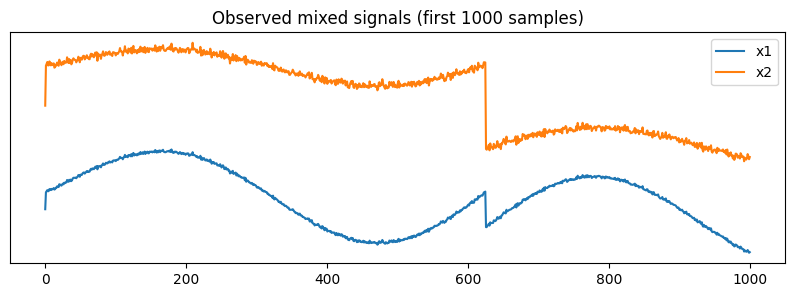

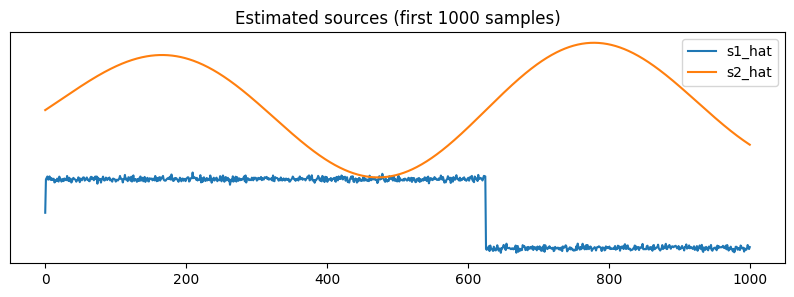

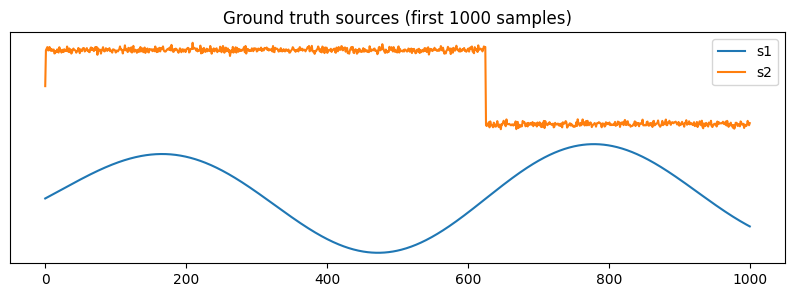

Correlation matrix (abs):
 [[0.    1.   ]
 [1.    0.001]]
Best matching permutation: (1, 0)
Average correlation (best pairing, abs): 1.0
ICA grading check: PASSED


In [23]:
def plot_signals(signals, title="Signals", labels=None, sample=1000):
    plt.figure(figsize=(10,3))
    time = np.arange(signals.shape[0])[:sample]
    for i in range(signals.shape[1]):
        plt.plot(time, signals[:sample, i] + 3*i, label=(labels[i] if labels else f"S{i}"))
    plt.title(title)
    plt.yticks([])
    plt.legend(loc='upper right')
    plt.show()

# Show mixed signals (for reference)
plot_signals(X_mixed, title="Observed mixed signals (first 1000 samples)", labels=["x1", "x2"])


ica = ICA(n_components=2, max_iters=1000, tol=1e-6, random_state=0)
S_est = ica.fit_transform(X_mixed)

# Plot estimated sources vs ground truth (first 1000 samples)
plot_signals(S_est, title="Estimated sources (first 1000 samples)", labels=["s1_hat", "s2_hat"])
plot_signals(S_true, title="Ground truth sources (first 1000 samples)", labels=["s1", "s2"])




# Compute correlation matrix between estimated sources and ground truth
S_hat = S_est.copy()
S_true_centered = S_true - np.mean(S_true, axis=0)
S_hat_centered = S_hat - np.mean(S_hat, axis=0)


S_true_norm = S_true_centered / (np.std(S_true_centered, axis=0) + 1e-12)
S_hat_norm = S_hat_centered / (np.std(S_hat_centered, axis=0) + 1e-12)


C = np.abs(np.corrcoef(S_true_norm.T, S_hat_norm.T)[:2, 2:4])

# Find best permutation and sign (abs used)
best = 0.0
best_pairs = None
import itertools
for perm in itertools.permutations([0,1]):
    score = C[0, perm[0]] + C[1, perm[1]]
    if score > best:
        best = score
        best_pairs = perm

avg_corr = best / 2.0
print("Correlation matrix (abs):\n", np.round(C, 3))
print("Best matching permutation:", best_pairs)
print("Average correlation (best pairing, abs):", round(avg_corr, 4))

assert avg_corr >= 0.90, "Recovered sources do not correlate well enough with ground truth (avg corr < 0.90)."
print("ICA grading check: PASSED")


## **Part C — Downstream application on MNIST (Pseudo-label pipeline)**

In many real-world applications, collecting **labeled data** is expensive or even impossible, while unlabeled data is abundant.  
Unsupervised learning provides a way to extract structure from such raw data, and a common strategy is to first discover clusters and then treat them as **pseudo-labels** for downstream tasks.

In this part, we will simulate this situation using the MNIST dataset.  
Although MNIST comes with ground truth labels (digits 0–9), we will deliberately **pretend that labels are not available**.  
This allows you to experience how to build a working classification pipeline without direct supervision.

The idea is to combine unsupervised clustering with the supervised methods you implemented in **Assignment 1** (e.g., logistic regression).  
Since you have already implemented logistic regression in Assignment 1, in this question you may directly call the provided implementation or a standard library version.

Steps:

1. Apply **PCA** to reduce MNIST (784-dimensional) to a lower-dimensional representation.  
2. Run **K-Means clustering** on the PCA features to generate pseudo-labels.  
3. Train a **logistic regression classifier** using the pseudo-labels (instead of the true labels).  
4. Evaluate and report the performance compared to random guessing.  
5. Visualize the embeddings:  
   - PCA (2D) projection, colored by pseudo-labels.  
   - t-SNE (2D) projection, also colored by pseudo-labels.  
   Compare qualitatively how t-SNE and PCA differ in separating the digit clusters.

⚠️ **Important**:  
- You must **not use the ground truth labels** for training.  
- The ground truth labels will only be used internally for grading and visualization.  

**Scoring (6pts points)**  
- Correct pipeline: PCA (Part A) → K-Means (Q1 Part A) → pseudo-labels → logistic regression → t-SNE visualization.  
- **Pseudo-label logistic regression accuracy ≥ 0.95** on the test set.  
- Visualization of the 2D t-SNE embedding is required.  
  - **t-SNE embedding must show clear cluster separation, with silhouette score ≥ 0.2**.  




Train shape: (10000, 784) Test shape: (2000, 784)


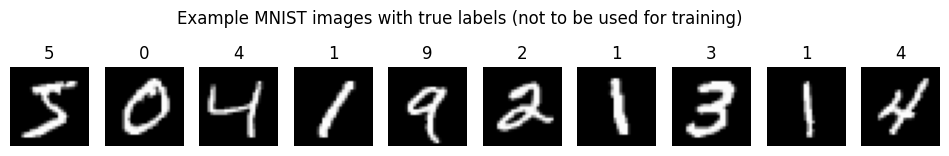

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Load MNIST dataset
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
X, y_true = mnist.data, mnist.target.astype(int)
X = X / 255.0

# Use a subset for speed
X_train, y_train = X[:10000], y_true[:10000]
X_test, y_test = X[10000:12000], y_true[10000:12000]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Show a few MNIST samples (with true labels, for reference only)
fig, axes = plt.subplots(1, 10, figsize=(12, 2))
for i in range(10):
    axes[i].imshow(X_train[i].reshape(28, 28), cmap="gray")
    axes[i].set_title(str(y_train[i]))
    axes[i].axis("off")
plt.suptitle("Example MNIST images with true labels (not to be used for training)")
plt.show()


Pseudo-labels distribution: [1423 1494  754 1129  472 1034 1477  740  939  538]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


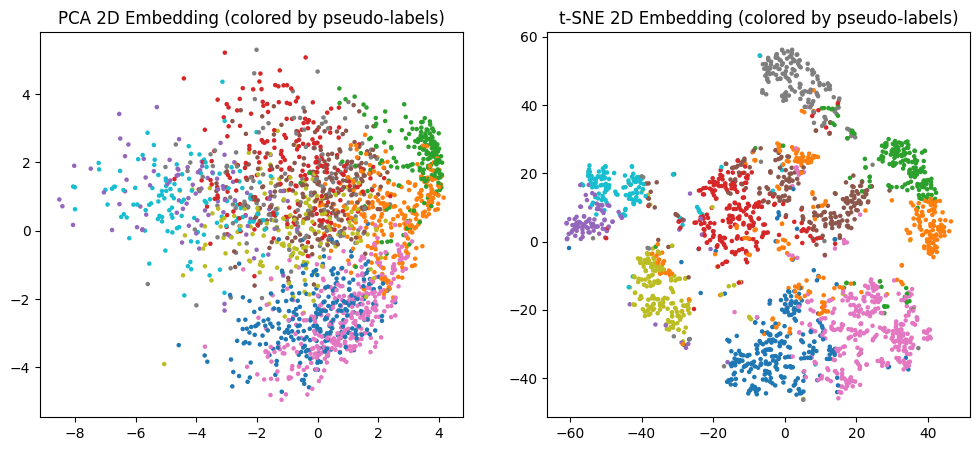

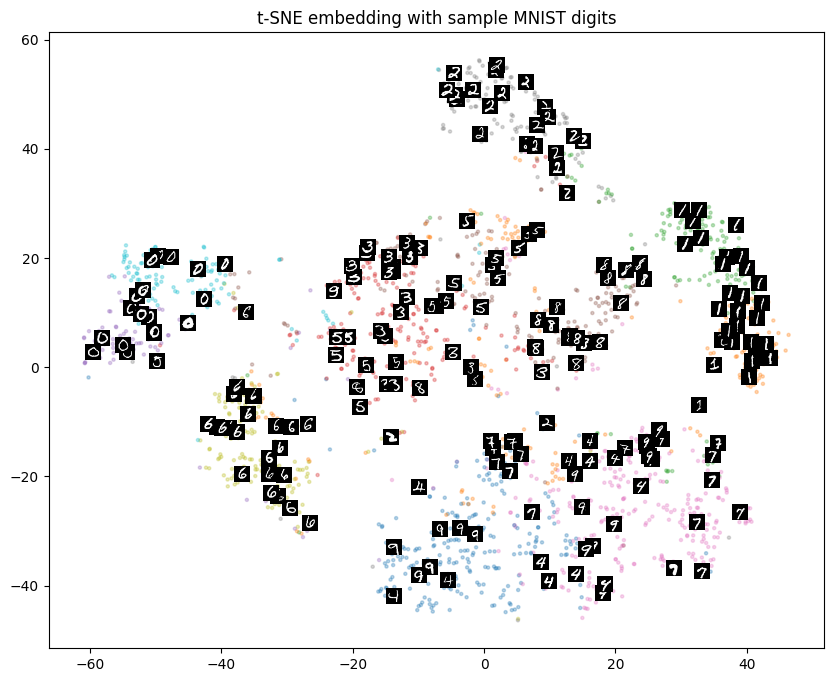

In [25]:
# Part C: Step 1 — PCA reduction and K-Means clustering

# Use your PCA implementation from Part A (not sklearn)
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Use your KMeans implementation from Q1 Part A (not sklearn)
kmeans = KMeans(n_clusters=10, init="kmeans++", random_state=42)
kmeans.fit(X_train_pca)
pseudo_labels = kmeans.labels_

print("Pseudo-labels distribution:", np.bincount(pseudo_labels))

# Part C: Step 2 — Train logistic regression on pseudo-labels

# TODO: Train logistic regression using pseudo-labels (you may use sklearn here)
logreg = LogisticRegression(
    max_iter=2000, C=100.0, multi_class="multinomial", solver="lbfgs", random_state=0
)
logreg.fit(X_train_pca, pseudo_labels)

# TODO: Predict on test set (using PCA features)
pseudo_pred = logreg.predict(X_test_pca)

# Part C: Step 3 — Visualization (PCA vs t-SNE)

# TODO: Project test set to 2D using your PCA implementation (from Part A)
pca2d = PCA(n_components=2)
pca2d.fit(X_train)                 # fit on train to avoid leakage
X_test_pca2d = pca2d.transform(X_test)

# TODO: Apply t-SNE to project the test set to 2D
# You can directly use sklearn.manifold.TSNE (no need to implement it yourself)
# Hint: Try different values of perplexity (e.g., 20, 30, 40) and observe how the embedding changes
tsne = TSNE(n_components=2, perplexity=30, init="pca", learning_rate="auto", random_state=42)
X_test_tsne2d = tsne.fit_transform(X_test_pca)

# Plot PCA embedding
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(X_test_pca2d[:,0], X_test_pca2d[:,1], c=pseudo_pred, cmap="tab10", s=5)
plt.title("PCA 2D Embedding (colored by pseudo-labels)")

# Plot t-SNE embedding
plt.subplot(1,2,2)
plt.scatter(X_test_tsne2d[:,0], X_test_tsne2d[:,1], c=pseudo_pred, cmap="tab10", s=5)
plt.title("t-SNE 2D Embedding (colored by pseudo-labels)")
plt.show()

# Part C: Step 4 — t-SNE embedding with digit thumbnails (optional, visualization only)

def imscatter(x, y, images, ax=None, zoom=0.5):
    if ax is None:
        ax = plt.gca()
    artists = []
    for x0, y0, img in zip(x, y, images):
        im = OffsetImage(img.reshape(28,28), cmap="gray", zoom=zoom)
        ab = AnnotationBbox(im, (x0, y0), frameon=False)
        artists.append(ax.add_artist(ab))
    return artists

# Pick 200 random samples to overlay (to avoid clutter)
idx = np.random.choice(len(X_test), 200, replace=False)

plt.figure(figsize=(10,8))
plt.scatter(X_test_tsne2d[:,0], X_test_tsne2d[:,1], c=pseudo_pred, cmap="tab10", s=5, alpha=0.3)
imscatter(X_test_tsne2d[idx,0], X_test_tsne2d[idx,1], X_test[idx], zoom=0.4)
plt.title("t-SNE embedding with sample MNIST digits")
plt.show()




⚠️ **Do not modify this cell** — any changes will result in a score of **0** for your implementation of this problem.




In [26]:
# ⚠️ Do not modify this cell (grading)

from sklearn.metrics import silhouette_score

# Check accuracy
baseline_acc = 0.95
distances_test = kmeans.compute_distances(X_test_pca, kmeans.centroids)
labels_test = kmeans.assign_clusters(distances_test)
acc = accuracy_score(pseudo_pred, labels_test)

# Check cluster quality in t-SNE space
sil_score = silhouette_score(X_test_tsne2d, pseudo_pred)

print(f"Pseudo-label logistic regression accuracy: {acc:.3f}")
print(f"Silhouette score on t-SNE embedding: {sil_score:.3f}")

if acc < baseline_acc:
    print("❌ Accuracy too low (< 0.95).")
elif sil_score < 0.2:
    print("❌ t-SNE embedding does not show clear clusters (silhouette < 0.2).")
else:
    print("✅ Correct: Your pipeline passes accuracy and visualization checks.")


Pseudo-label logistic regression accuracy: 0.970
Silhouette score on t-SNE embedding: 0.209
✅ Correct: Your pipeline passes accuracy and visualization checks.


### Question

**1. (1 point)**  
Why does PCA choose directions corresponding to the largest eigenvalues of the covariance matrix?  
**Answer:**  

Because those eigenvectors maximize the **projected variance** and, equivalently, minimize the **reconstruction error** among all rank-𝑘 linear projections (Eckart–Young). The covariance’s eigenvalues equal the variance along their eigenvectors, so choosing the largest eigenvalues keeps the directions with the most information/energy.

---

**2. (1 point)**  
Why can ICA separate mixed audio signals while PCA cannot?  
**Answer:**  

PCA only **decorrelates** data and orders orthogonal directions by variance (a second-order statistic). ICA exploits **higher-order statistics** and the **non-Gaussian**, **independent** source assumption: after whitening, it finds a rotation that makes components **statistically independent**, allowing recovery of individual sources up to permutation/sign—something PCA cannot guarantee.

---

**3. (1 point)**  
What kind of structure does t-SNE preserve better than PCA when visualizing high-dimensional data?  
**Answer:**  

**Local neighborhood structure**. t-SNE preserves pairwise **similarity of nearby points** (local manifolds/cluster structure), often revealing well-separated clusters, while sacrificing global distances/axes, which PCA emphasizes.

---

**4. (1 point)**  
Why can logistic regression trained on pseudo-labels from clustering still achieve high accuracy?  
**Answer:**  

Under the **cluster assumption**, samples form well-separated groups that align with classes; pseudo-labels are thus high-purity approximations of true labels. Logistic regression then learns simple **linear boundaries** that closely mimic the cluster assignments (effectively distilling the clusterer), and with many samples it is robust to the small amount of label noise.


# **Question 3: Convolutional Neural Networks (CNNs)**

In this question, you will implement and train **Convolutional Neural Networks (CNNs)** completely from scratch.  
You will first build a CNN with all standard training components, then extend it to more advanced architectures like **ResNet** and **Depth-wise Separable Convolution (as used in MobileNet)**.

**Grading**: This question is worth **20 points total**.


## **Part A — Build & Train CNN on MNIST**

In this part, you will implement a complete CNN from scratch using **NumPy only**.  
Your CNN should include the following components:

- Conv2D (forward + backward)
- Pooling (Max/Avg)
- Fully Connected layer
- Activation functions (ReLU, Softmax)
- Training tricks: Dropout, Batch Normalization

You will then train your CNN classifier on MNIST, and compare the results with the baseline MLP you implemented in **Assignment 1**.

### Scoring (5 points)
- Correct implementation of **forward and backward propagation** for Conv2D, Pooling, and FC layers.  
- Correct implementation of Dropout and Batch Normalization.  
- Achieve **test accuracy ≥ 0.97** on MNIST.  
- Provide training/test accuracy curves to show convergence.  


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

np.random.seed(2025)

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist['data'].astype(np.float32) / 255.0
y = mnist['target'].astype(np.int64)
X = X.reshape(-1, 1, 28, 28)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000, random_state=42, stratify=y
)

num_classes = 10
def one_hot(labels, C):
    out = np.zeros((labels.shape[0], C), dtype=np.float32)
    out[np.arange(labels.shape[0]), labels] = 1.0
    return out

Y_train = one_hot(y_train, num_classes)
Y_test  = one_hot(y_test,  num_classes)

print("Train:", X_train.shape, Y_train.shape)
print("Test :", X_test.shape, Y_test.shape)


Train: (60000, 1, 28, 28) (60000, 10)
Test : (10000, 1, 28, 28) (10000, 10)


In [30]:
# Part A — Implement CNN with BatchNorm and Dropout (NumPy only)


def im2col(X, kH, kW, pad, stride):
    # TODO: unfold input tensor into columns
    # Hint:
    #   1. Use np.pad to pad the input
    #   2. Extract sliding windows for convolution
    # X: (N,C,H,W) -> cols: (C*kH*kW, N*out_h*out_w)
    N, C, H, W = X.shape
    Hp, Wp = H + 2*pad, W + 2*pad
    out_h = (Hp - kH) // stride + 1
    out_w = (Wp - kW) // stride + 1

    Xp = np.pad(X, ((0,0),(0,0),(pad,pad),(pad,pad)), mode='constant')
    sN, sC, sH, sW = Xp.strides
    shape = (N, C, out_h, out_w, kH, kW)
    strides = (sN, sC, sH*stride, sW*stride, sH, sW)
    windows = np.lib.stride_tricks.as_strided(Xp, shape=shape, strides=strides)
    cols = np.ascontiguousarray(windows).transpose(1,4,5,0,2,3).reshape(C*kH*kW, -1)
    return cols, out_h, out_w


def col2im(cols, X_shape, kH, kW, pad, stride, out_h, out_w):
    # TODO: reconstruct image tensor from column representation
    # Hint: accumulate overlapping regions
    # inverse of im2col used above
    N, C, H, W = X_shape
    Hp, Wp = H + 2*pad, W + 2*pad
    Xp = np.zeros((N, C, Hp, Wp), dtype=cols.dtype)

    cols = cols.reshape(C, kH, kW, N, out_h, out_w).transpose(3,0,4,5,1,2)
    # scatter-add
    for i in range(kH):
        for j in range(kW):
            Xp[:, :, i:i+stride*out_h:stride, j:j+stride*out_w:stride] += cols[:, :, :, :, i, j]

    if pad > 0:
        return Xp[:, :, pad:-pad, pad:-pad]
    return Xp


class Conv2D:
    def __init__(self, in_c, out_c, k=3, stride=1, padding='same'):
        self.in_c, self.out_c, self.k, self.stride = in_c, out_c, k, stride
        self.pad = k // 2 if padding == 'same' else 0
        scale = np.sqrt(2.0 / (in_c * k * k))
        self.W = (np.random.randn(out_c, in_c, k, k) * scale).astype(np.float32)
        self.b = np.zeros((out_c, 1), dtype=np.float32)

    def forward(self, X):
        self.X = X
        self.cols, self.oh, self.ow = im2col(X, self.k, self.k, self.pad, self.stride)
        out = (self.W.reshape(self.out_c, -1) @ self.cols + self.b).reshape(
            self.out_c, X.shape[0], self.oh, self.ow).transpose(1, 0, 2, 3)
        return out

    def backward(self, dY):
        dY_r = dY.transpose(1, 0, 2, 3).reshape(self.out_c, -1)
        self.db = dY_r.sum(axis=1, keepdims=True)
        self.dW = (dY_r @ self.cols.T).reshape(self.W.shape)
        dcols = self.W.reshape(self.out_c, -1).T @ dY_r
        dX = col2im(dcols, self.X.shape, self.k, self.k, self.pad, self.stride, self.oh, self.ow)
        return dX


class BatchNorm2D:
    def __init__(self, num_features, eps=1e-5, momentum=0.9):
        self.gamma = np.ones((1, num_features, 1, 1), dtype=np.float32)
        self.beta  = np.zeros((1, num_features, 1, 1), dtype=np.float32)
        self.running_mean = np.zeros((1, num_features, 1, 1), dtype=np.float32)
        self.running_var  = np.ones((1, num_features, 1, 1), dtype=np.float32)
        self.eps = eps
        self.momentum = momentum

    def forward(self, X, training=True):

        if training:
          # TODO: normalize batch and apply affine transform
          # Hint:
          #   1. Compute mean and var along N,H,W
          #   2. Update running mean/var during training
          mean = X.mean(axis=(0,2,3), keepdims=True)
          var  = X.var(axis=(0,2,3), keepdims=True)
          self.running_mean = self.momentum*self.running_mean + (1-self.momentum)*mean
          self.running_var  = self.momentum*self.running_var  + (1-self.momentum)*var
          self.X_centered = X - mean
          self.std_inv = 1.0 / np.sqrt(var + self.eps)
          X_norm = self.X_centered * self.std_inv
        else:
          X_norm = (X - self.running_mean) / np.sqrt(self.running_var + self.eps)
          self.X_centered = X - self.running_mean
          self.std_inv = 1.0 / np.sqrt(self.running_var + self.eps)
        self.X_norm = X_norm
        out = self.gamma * X_norm + self.beta
        return out

    def backward(self, dY):
        N, C, H, W = dY.shape
        self.dgamma = np.sum(dY * self.X_norm, axis=(0,2,3), keepdims=True)
        self.dbeta  = np.sum(dY, axis=(0,2,3), keepdims=True)
        dX_norm = dY * self.gamma
        dvar = np.sum(dX_norm * self.X_centered * -0.5 * self.std_inv**3, axis=(0,2,3), keepdims=True)
        dmean = np.sum(-dX_norm * self.std_inv, axis=(0,2,3), keepdims=True) + \
                dvar * np.mean(-2.0 * self.X_centered, axis=(0,2,3), keepdims=True)
        dX = dX_norm * self.std_inv + dvar * 2.0 * self.X_centered / (N*H*W) + dmean / (N*H*W)
        return dX


class ReLU:
    def forward(self, X):
        # TODO: element-wise activation
        self.mask = (X > 0).astype(X.dtype)
        return X * self.mask

    def backward(self, dY):
        # TODO: propagate gradient only through positive inputs
        return dY * self.mask

class MaxPool2D:
    def __init__(self, k=2, stride=2):
        self.k, self.stride = k, stride

    def forward(self, X):

        self.X_shape = X.shape
        N, C, H, W = X.shape
        # TODO: perform max pooling using im2col
        cols, self.oh, self.ow = im2col(X, self.k, self.k, pad=0, stride=self.stride)
        K2 = self.k * self.k
        cols = cols.reshape(C, K2, -1)              # (C, K2, N*oh*ow)
        self.argmax = np.argmax(cols, axis=1)       # (C, N*oh*ow)
        out = np.max(cols, axis=1).reshape(C, N, self.oh, self.ow).transpose(1,0,2,3)
        return out

    def backward(self, dY):
        N, C, _, _ = dY.shape
        K2 = self.k * self.k
        dcols = np.zeros((N, C, self.oh, self.ow, K2), dtype=dY.dtype)
        flat = dcols.reshape(-1, K2)
        flat[np.arange(flat.shape[0]), self.argmax.reshape(-1)] = 1.0
        dcols = dcols * dY[..., None]
        dcols = dcols.transpose(1, 4, 0, 2, 3).reshape(C*K2, -1)
        dX = col2im(dcols, self.X_shape, self.k, self.k, pad=0, stride=self.stride,
                    out_h=self.oh, out_w=self.ow)
        return dX


class Dropout:
    def __init__(self, p=0.5):
        self.p = p

    def forward(self, X, training=True):

        if training:
        # TODO: randomly drop activations during training
        # Hint: scale activations by 1/(1-p) to keep expectation
            self.mask = (np.random.rand(*X.shape) > self.p).astype(X.dtype) / (1.0 - self.p)
            return X * self.mask

        else:
            return X

    def backward(self, dY):
        # TODO: apply same dropout mask to gradients
        return dY * getattr(self, "mask", 1.0)

class Linear:
    def __init__(self, in_f, out_f):
        scale = np.sqrt(2.0 / in_f)
        self.W = (np.random.randn(in_f, out_f) * scale).astype(np.float32)
        self.b = np.zeros((1, out_f), dtype=np.float32)

    def forward(self, X):
        # TODO: fully connected forward
        self.X = X
        return X @ self.W + self.b

    def backward(self, dY):
        self.dW = self.X.T @ dY
        self.db = dY.sum(axis=0, keepdims=True)
        dX = dY @ self.W.T
        return dX

class SoftmaxCrossEntropy:
    def forward(self, logits, Y_true):
        # TODO: compute softmax cross-entropy loss
        self.Y_true = Y_true
        logits = logits - logits.max(axis=1, keepdims=True)
        exp = np.exp(logits)
        self.prob = exp / (exp.sum(axis=1, keepdims=True) + 1e-12)
        loss = -np.sum(Y_true * np.log(self.prob + 1e-12)) / logits.shape[0]
        return loss

    def backward(self):
        # TODO: compute gradient wrt logits
        N = self.Y_true.shape[0]
        return (self.prob - self.Y_true) / N


class SGD:
    def __init__(self, params, lr=0.01, weight_decay=0.0):
        self.params = params
        self.lr = lr
        self.wd = weight_decay

    def step(self):
        # TODO: update trainable parameters
        for layer in self.params:
            if hasattr(layer, "W") and hasattr(layer, "b"):
                layer.W -= self.lr * (getattr(layer, "dW", 0) + self.wd * layer.W)
                layer.b -= self.lr * (getattr(layer, "db", 0))
            if hasattr(layer, "gamma") and hasattr(layer, "beta"):
                layer.gamma -= self.lr * getattr(layer, "dgamma", 0)
                layer.beta  -= self.lr * getattr(layer, "dbeta", 0)

class SimpleCNN:
    def __init__(self):
        self.c1 = Conv2D(1, 8, k=3, padding='same')
        self.bn1 = BatchNorm2D(8)
        self.r1 = ReLU()
        self.p1 = MaxPool2D(k=2, stride=2)
        self.d1 = Dropout(p=0.25)

        self.c2 = Conv2D(8, 16, k=3, padding='same')
        self.bn2 = BatchNorm2D(16)
        self.r2 = ReLU()
        self.p2 = MaxPool2D(k=2, stride=2)
        self.d2 = Dropout(p=0.25)

        self.fc  = Linear(16*7*7, 10)
        self.crit = SoftmaxCrossEntropy()
        self.params = [self.c1, self.bn1, self.c2, self.bn2, self.fc]

    def forward(self, X, training=True):
        # TODO: define CNN forward pass with BN and Dropout
        # Hint:
        #   1. Conv -> BatchNorm -> ReLU -> MaxPool -> Dropout
        #   2. Repeat the same for the second Conv block
        #   3. Flatten and pass through the final FC layer
        x = self.c1.forward(X)
        x = self.bn1.forward(x, training=training)
        x = self.r1.forward(x)
        x = self.p1.forward(x)
        x = self.d1.forward(x, training=training)

        x = self.c2.forward(x)
        x = self.bn2.forward(x, training=training)
        x = self.r2.forward(x)
        x = self.p2.forward(x)
        x = self.d2.forward(x, training=training)

        self.flatten_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        logits = self.fc.forward(x)
        return logits

    def loss(self, logits, Y):
        # TODO: compute classification loss
        return self.crit.forward(logits, Y)

    def backward(self):
        # TODO: backpropagate through all layers
        d = self.crit.backward()
        d = self.fc.backward(d).reshape(self.flatten_shape)

        d = self.d2.backward(d)
        d = self.p2.backward(d)
        d = self.r2.backward(d)
        d = self.bn2.backward(d)
        d = self.c2.backward(d)

        d = self.d1.backward(d)
        d = self.p1.backward(d)
        d = self.r1.backward(d)
        d = self.bn1.backward(d)
        _ = self.c1.backward(d)

    def parameters(self):
        return self.params


def iterate_minibatches(X, Y, batch_size=128, shuffle=True):
    idx = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(idx)
    for s in range(0, len(idx), batch_size):
        e = s + batch_size
        b = idx[s:e]
        yield X[b], Y[b]


def accuracy(model, X, y, batch_size=512):
    correct, total = 0, 0
    for Xb, yb in iterate_minibatches(X, y, batch_size=batch_size, shuffle=False):
        logits = model.forward(Xb, training=False)
        pred = logits.argmax(axis=1)
        correct += (pred == yb).sum()
        total += yb.size
    return correct / total


⚠️ **Do not modify this cell** — any changes will result in a score of **0**.


Epoch 01 | Loss 0.5590 | TrainAcc 0.9501 | TestAcc 0.9465
Epoch 02 | Loss 0.2593 | TrainAcc 0.9612 | TestAcc 0.9579
Epoch 03 | Loss 0.2167 | TrainAcc 0.9668 | TestAcc 0.9657
Epoch 04 | Loss 0.1906 | TrainAcc 0.9708 | TestAcc 0.9685
Epoch 05 | Loss 0.1739 | TrainAcc 0.9709 | TestAcc 0.9681


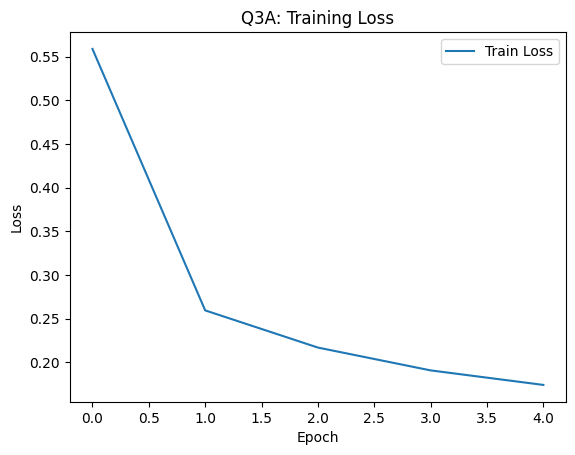

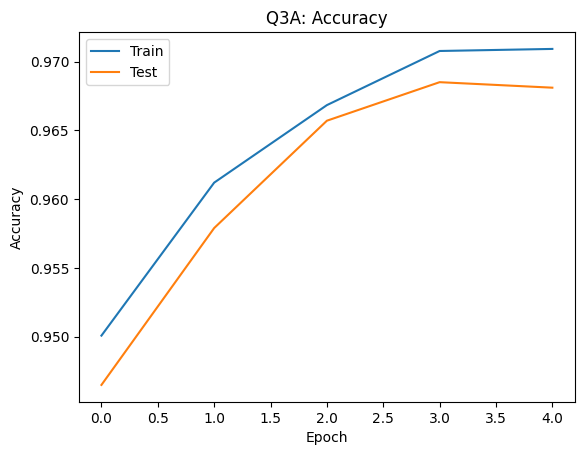

In [31]:
model = SimpleCNN()
opt = SGD(model.parameters(), lr=0.05, weight_decay=5e-4)

epochs = 5
batch_size = 128
train_losses, train_accs, test_accs = [], [], []

for ep in range(1, epochs + 1):
    loss_sum, steps = 0.0, 0
    for Xb, Yb in iterate_minibatches(X_train, Y_train, batch_size=batch_size, shuffle=True):
        logits = model.forward(Xb, training=True)
        loss = model.loss(logits, Yb)
        model.backward()
        opt.step()
        loss_sum += loss
        steps += 1

    tr_acc = accuracy(model, X_train, y_train, batch_size=512)
    te_acc = accuracy(model, X_test,  y_test,  batch_size=512)
    train_losses.append(loss_sum / steps)
    train_accs.append(tr_acc)
    test_accs.append(te_acc)
    print(f"Epoch {ep:02d} | Loss {loss_sum/steps:.4f} | TrainAcc {tr_acc:.4f} | TestAcc {te_acc:.4f}")

# Train loss curve
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Q3A: Training Loss")
plt.legend()
plt.show()

# Accuracy curves
plt.figure()
plt.plot(train_accs, label="Train")
plt.plot(test_accs, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Q3A: Accuracy")
plt.legend()
plt.show()



## **Part B — ResNet Block on CIFAR-10**

In this part, you will extend your CNN implementation by adding **Residual Connections (ResNet Blocks)**,  
and train the model on the **CIFAR-10** dataset (or a subset for faster training).  
This task introduces the concept of *skip connections*, which help deep networks converge faster and reduce vanishing gradients.

### 🧠 Objective
Implement and compare two CNN architectures:
1. **Plain CNN** – a simple stacked Conv → ReLU → Pool pipeline.  
2. **ResNet CNN** – uses Residual Blocks (`y = F(x) + x`) to improve convergence.

### 🧩 Required Components
- Residual Block (`ResBlock`):  
  - Two Conv-BN-ReLU layers  
  - Skip connection `y = F(x) + x`  
  - Optional 1×1 Conv when channel/shape mismatch occurs
- Updated CNN model using ResBlocks  
- Training loop identical to Part A (SGD, cross-entropy loss)

### 🧾 Scoring (6 points)
- Correct forward and backward implementation of `ResBlock`.  
- Proper integration of skip connections in `ResNetCNN`.  
- ResNet model achieves **higher test accuracy or faster convergence** than the Plain CNN baseline.  
- **ResNetCNN should achieve test accuracy ≥ 0.45 on the provided subset.**


### ⚙️ Restrictions
- Use **NumPy only** (no PyTorch or TensorFlow).  
- You may reuse Conv2D, BatchNorm2D, ReLU, MaxPool2D, Dropout, Linear, and SGD from Part A.


In [32]:
import numpy as np
from tensorflow.keras.datasets import cifar10

np.random.seed(2025)

# Load CIFAR-10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# ⚠️ Subsample for faster training (about 1/5 of dataset)
# To keep runtime reasonable under NumPy-only convolution (no GPU acceleration),
# we use only the first 10,000 training samples and 2,000 test samples.
X_train, y_train = X_train[:10000], y_train[:10000]
X_test,  y_test  = X_test[:2000],  y_test[:2000]

# Flatten labels
y_train = y_train.flatten()
y_test  = y_test.flatten()

# Normalize to [0,1]
X_train = X_train.astype(np.float32) / 255.0
X_test  = X_test.astype(np.float32) / 255.0

# Transpose to (N, C, H, W)
X_train = X_train.transpose(0, 3, 1, 2)
X_test  = X_test.transpose(0, 3, 1, 2)

# One-hot encoding
num_classes = 10
def one_hot(labels, C):
    out = np.zeros((labels.shape[0], C), dtype=np.float32)
    out[np.arange(labels.shape[0]), labels] = 1.0
    return out

Y_train = one_hot(y_train, num_classes)
Y_test  = one_hot(y_test,  num_classes)

print("Train:", X_train.shape, Y_train.shape)
print("Test :", X_test.shape, Y_test.shape)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Train: (10000, 3, 32, 32) (10000, 10)
Test : (2000, 3, 32, 32) (2000, 10)


In [37]:
# Part B — Implement ResNet Block and Compare with Plain CNN (NumPy only)

class ResBlock:
    def __init__(self, in_c, out_c, use_projection=False):
        self.use_projection = use_projection
        self.c1 = Conv2D(in_c, out_c, k=3, padding='same')
        self.bn1 = BatchNorm2D(out_c)
        self.r1 = ReLU()
        self.c2 = Conv2D(out_c, out_c, k=3, padding='same')
        self.bn2 = BatchNorm2D(out_c)
        self.r2 = ReLU()
        self.proj = Conv2D(in_c, out_c, k=1, padding='same') if use_projection else None

    def forward(self, X, training=True):
        # TODO: implement residual forward pass
        # Hint:
        #   1. compute F(x) through two Conv-BN-ReLU layers
        #   2. if channel mismatch, use projection conv
        #   3. output = F(x) + shortcut
        # main branch F(x)
        h = self.c1.forward(X)
        h = self.bn1.forward(h, training=training)
        h = self.r1.forward(h)
        h = self.c2.forward(h)
        h = self.bn2.forward(h, training=training)

        # skip/shortcut
        self.shortcut = self.proj.forward(X) if self.use_projection else X

        out = h + self.shortcut

        out = self.r2.forward(out)  # reuse ReLU for final activation
        return out

    def backward(self, dY):
        # TODO: implement backward for residual block
        # Hint:
        #   1. gradient splits through both residual and skip paths
        #   2. sum gradients from both branches
        # through final ReLU
        d = self.r2.backward(dY)

        # split to branches
        d_main = self.bn2.backward(d)
        d_main = self.c2.backward(d_main)
        d_main = self.r1.backward(d_main)
        d_main = self.bn1.backward(d_main)
        d_main = self.c1.backward(d_main)

        d_skip = self.proj.backward(d) if self.use_projection else d  # identity grad

        return d_main + d_skip

    def parameters(self):
        layers = [self.c1, self.bn1, self.c2, self.bn2]
        if self.use_projection:
            layers.append(self.proj)
        return layers



class PlainCNN:
    def __init__(self):
        self.c1 = Conv2D(3, 32, k=3, padding='same')
        self.bn1 = BatchNorm2D(32)
        self.r1 = ReLU()
        self.p1 = MaxPool2D(k=2, stride=2)

        self.c2 = Conv2D(32, 64, k=3, padding='same')
        self.bn2 = BatchNorm2D(64)
        self.r2 = ReLU()
        self.p2 = MaxPool2D(k=2, stride=2)

        self.fc = Linear(64*8*8, 10)
        self.crit = SoftmaxCrossEntropy()
        self.params = [self.c1, self.bn1, self.c2, self.bn2, self.fc]

    def forward(self, X, training=True):
        # TODO: implement plain CNN forward pass
        # Hint:
        #   1. Conv -> BatchNorm -> ReLU -> MaxPool
        #   2. Repeat for second Conv block
        #   3. Flatten and pass through FC layer
        x = self.c1.forward(X)
        x = self.bn1.forward(x, training=training)
        x = self.r1.forward(x)
        x = self.p1.forward(x)

        x = self.c2.forward(x)
        x = self.bn2.forward(x, training=training)
        x = self.r2.forward(x)
        x = self.p2.forward(x)

        self.flatten_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        logits = self.fc.forward(x)

        return logits


    def loss(self, logits, Y):
        return self.crit.forward(logits, Y)

    def backward(self):
        # TODO: backward pass for plain CNN
        d = self.crit.backward()
        d = self.fc.backward(d).reshape(self.flatten_shape)

        d = self.p2.backward(d)
        d = self.r2.backward(d)
        d = self.bn2.backward(d)
        d = self.c2.backward(d)

        d = self.p1.backward(d)
        d = self.r1.backward(d)
        d = self.bn1.backward(d)
        _ = self.c1.backward(d)

    def parameters(self):
        return self.params


class ResNetCNN:
    def __init__(self):
        self.c1 = Conv2D(3, 32, k=3, padding='same')
        self.bn1 = BatchNorm2D(32)
        self.r1 = ReLU()
        self.p1 = MaxPool2D(k=2, stride=2)

        self.res1 = ResBlock(32, 32, use_projection=False)
        self.res2 = ResBlock(32, 64, use_projection=True)
        self.p2 = MaxPool2D(k=2, stride=2)

        self.fc = Linear(64*8*8, 10)
        self.crit = SoftmaxCrossEntropy()
        self.params = [self.c1, self.bn1] + \
                      self.res1.parameters() + \
                      self.res2.parameters() + [self.fc]

    def forward(self, X, training=True):
        # TODO: implement forward with residual blocks
        # Hint:
        #   1) Conv-BN-ReLU-MaxPool: c1 -> bn1(training) -> r1 -> p1
        #   2) Residual block (no projection): res1.forward(x, training)
        #   3) Residual block (with projection): res2.forward(x, training)
        #   4) Spatial downsample: p2
        #   5) Flatten to (N, 64*8*8)
        #   6) Linear classifier: fc
        x = self.c1.forward(X)
        x = self.bn1.forward(x, training=training)
        x = self.r1.forward(x)
        x = self.p1.forward(x)

        x = self.res1.forward(x, training=training)
        x = self.res2.forward(x, training=training)
        x = self.p2.forward(x)

        self.flatten_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        logits = self.fc.forward(x)
        return logits

    def loss(self, logits, Y):
        return self.crit.forward(logits, Y)

    def backward(self):
        # TODO: backward through residual blocks
        # Hint (reverse order of forward):
        #   Start from dL/dlogits:
        #     1) crit.backward() -> gradient wrt logits
        #     2) fc.backward -> reshape to (N, 64, 8, 8)
        #     3) p2.backward
        #     4) res2.backward (handles projection skip internally)
        #     5) res1.backward
        #     6) p1.backward
        #     7) r1.backward
        #     8) bn1.backward
        #     9) c1.backward (ignore returned grad)
        d = self.crit.backward()
        d = self.fc.backward(d).reshape(self.flatten_shape)

        d = self.p2.backward(d)
        d = self.res2.backward(d)
        d = self.res1.backward(d)

        d = self.p1.backward(d)
        d = self.r1.backward(d)
        d = self.bn1.backward(d)
        _ = self.c1.backward(d)

    def parameters(self):
        return self.params



⚠️ **Do not modify this cell** — any changes will result in a score of **0** for Part B.



Epoch 01 | PlainAcc 0.2955 | ResNetAcc 0.2180
Epoch 02 | PlainAcc 0.3675 | ResNetAcc 0.3460
Epoch 03 | PlainAcc 0.2205 | ResNetAcc 0.3890
Epoch 04 | PlainAcc 0.3295 | ResNetAcc 0.3370
Epoch 05 | PlainAcc 0.2935 | ResNetAcc 0.4835
Epoch 06 | PlainAcc 0.3935 | ResNetAcc 0.3615
Epoch 07 | PlainAcc 0.4425 | ResNetAcc 0.3940
Epoch 08 | PlainAcc 0.3315 | ResNetAcc 0.4360
Epoch 09 | PlainAcc 0.2025 | ResNetAcc 0.4670
Epoch 10 | PlainAcc 0.4450 | ResNetAcc 0.3585


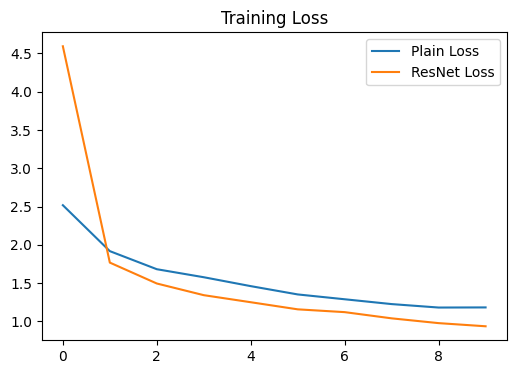

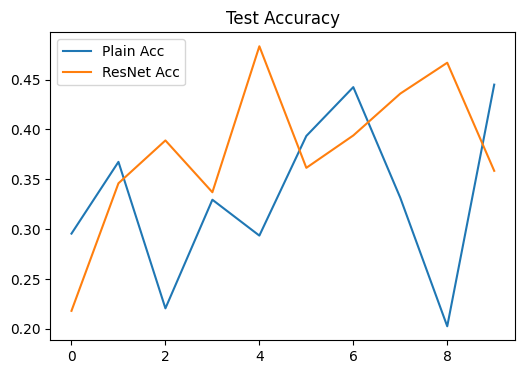

In [38]:
# assume X_train, X_test, Y_train, Y_test already loaded and preprocessed
plain = PlainCNN()
resnet = ResNetCNN()

opt_plain = SGD(plain.parameters(), lr=0.01, weight_decay=1e-4)
opt_res   = SGD(resnet.parameters(), lr=0.01, weight_decay=1e-4)

epochs = 10
batch_size = 128

plain_loss, res_loss = [], []
plain_acc, res_acc = [], []

for ep in range(1, epochs + 1):
    # Train Plain CNN
    Lp, steps = 0, 0
    for Xb, Yb in iterate_minibatches(X_train, Y_train, batch_size=batch_size):
        logits = plain.forward(Xb, training=True)
        loss = plain.loss(logits, Yb)
        plain.backward(); opt_plain.step()
        Lp += loss; steps += 1
    plain_loss.append(Lp/steps)
    plain_acc.append(accuracy(plain, X_test, y_test))

    # Train ResNet CNN
    Lr, steps = 0, 0
    for Xb, Yb in iterate_minibatches(X_train, Y_train, batch_size=batch_size):
        logits = resnet.forward(Xb, training=True)
        loss = resnet.loss(logits, Yb)
        resnet.backward(); opt_res.step()
        Lr += loss; steps += 1
    res_loss.append(Lr/steps)
    res_acc.append(accuracy(resnet, X_test, y_test))

    print(f"Epoch {ep:02d} | PlainAcc {plain_acc[-1]:.4f} | ResNetAcc {res_acc[-1]:.4f}")

plt.figure(figsize=(6,4))
plt.plot(plain_loss, label='Plain Loss')
plt.plot(res_loss, label='ResNet Loss')
plt.legend(); plt.title('Training Loss'); plt.show()

plt.figure(figsize=(6,4))
plt.plot(plain_acc, label='Plain Acc')
plt.plot(res_acc, label='ResNet Acc')
plt.legend(); plt.title('Test Accuracy'); plt.show()


## **Part C — Depthwise Convolution (MobileNet-lite)**

In this part, you will implement **Depthwise and Pointwise Convolution** from scratch using **NumPy only**,  
and build a lightweight CNN architecture inspired by **MobileNet**.

### 🧠 Objective
Replace standard convolution layers with:
1. **Depthwise Convolution (3×3):**  
   Each input channel has its own kernel and is convolved independently.
2. **Pointwise Convolution (1×1):**  
   Combines all channel outputs linearly to mix information across channels.

Together, they approximate the behavior of a standard convolution but with far fewer parameters and FLOPs.

### ⚙️ Tasks
- Implement `DepthwiseConv2D` (forward + backward).  
- Implement `PointwiseConv2D` (forward + backward).  
- Build a `MobileNetLite` model using these layers.  
- Compare the results with the **Plain CNN** from Part B in terms of:
  - Test accuracy.  
  - Total parameter count.  
  - Computation cost (FLOPs).  

### 🧾 Scoring ( 5 points)
To receive full credit, your implementation should:
- Correctly implement **depthwise** and **pointwise** convolution operations.  
- Successfully train the **MobileNet Lite** model without numerical errors.  
- Achieve **at least 75% reduction** in total parameters compared to the Plain CNN baseline.  
- Maintain a **test accuracy drop** no greater than **(parameter reduction − 30%)**.  
  - In other words, the accuracy drop (in %) must be **at least 30% smaller than the parameter reduction (in %)**.  
  - *Example:* if your parameter reduction = **86.45%**, your accuracy drop must be **≤ 56.45%**.  






In [39]:
# Part C — MobileNet-lite: Depthwise & Pointwise Convolution (NumPy only)

class DepthwiseConv2D:
    def __init__(self, in_channels, k=3, stride=1, padding='same'):
        self.in_channels = in_channels
        self.k = k
        self.stride = stride
        self.padding = padding
        self.pad = k // 2 if padding == 'same' else 0
        scale = np.sqrt(2.0 / (k * k * in_channels))
        self.W = np.random.randn(in_channels, 1, k, k) * scale
        self.b = np.zeros((in_channels, 1))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

    def forward(self, X):
        # TODO: Implement depthwise convolution (each channel convolved independently)
        # Hint: Reuse Conv2D logic but apply per-channel kernels only.
        # Hint: Each channel uses its own kernel, equivalent to groups=in_channels.
        self.X = X
        N, C, H, W = X.shape
        outs = []
        self.cache = []
        for c in range(C):
            cols, oh, ow = im2col(X[:, c:c+1, :, :], self.k, self.k, self.pad, self.stride)
            y = (self.W[c].reshape(1, -1) @ cols + self.b[c]).reshape(1, N, oh, ow).transpose(1,0,2,3)
            outs.append(y)
            self.cache.append(cols)
        self.oh, self.ow = oh, ow
        out = np.concatenate(outs, axis=1)  # (N,C,oh,ow)
        return out

    def backward(self, d_out):

        X = self.X
        N, C, H, W = X.shape
        # TODO: Implement backward pass for depthwise conv
        # Hint: Derivatives are similar to Conv2D but handled per channel.
        # Hint: Compute dW, dX per channel and normalize by batch size.
        dX = np.zeros_like(X)
        self.dW[:] = 0.; self.db[:] = 0.
        for c in range(C):
            dY = d_out[:, c:c+1, :, :].transpose(1,0,2,3).reshape(1, -1)   # (1, N*oh*ow)
            cols = self.cache[c]                                           # (k*k, N*oh*ow)
            self.db[c] = dY.sum(axis=1, keepdims=True)
            self.dW[c] = (dY @ cols.T).reshape(1, self.k, self.k)
            dcols = self.W[c].reshape(1, -1).T @ dY
            dX[:, c:c+1, :, :] += col2im(dcols, (N,1,H,W), self.k, self.k, self.pad, self.stride, self.oh, self.ow)
        return dX


class PointwiseConv2D:
    def __init__(self, in_channels, out_channels):
        self.in_channels = in_channels
        self.out_channels = out_channels
        scale = np.sqrt(2.0 / in_channels)
        self.W = np.random.randn(out_channels, in_channels, 1, 1) * scale
        self.b = np.zeros((out_channels, 1))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

    def forward(self, X):
        # TODO: Implement 1×1 convolution mixing all input channels
        # Hint: This is a matrix multiplication across the channel dimension.
        # Hint: Treat each spatial position as a vector and apply out×in weights.
        self.X = X
        N, Cin, H, W = X.shape
        Xr = X.transpose(0,2,3,1).reshape(-1, Cin)                  # (N*H*W, Cin)
        Wr = self.W.reshape(self.out_channels, Cin).T               # (Cin, Cout)
        Yr = Xr @ Wr + self.b.reshape(1, -1)                        # (N*H*W, Cout)
        out = Yr.reshape(N, H, W, self.out_channels).transpose(0,3,1,2)
        return out

    def backward(self, d_out):
        # TODO: Implement backward pass for pointwise conv
        # Hint: Accumulate gradients for each 1×1 kernel, use keepdims=True.
        # Hint: dW[o,c,1,1] = sum_{n,h,w} X[n,c,h,w]*d_out[n,o,h,w]
        N, Cout, H, W = d_out.shape
        Cin = self.X.shape[1]
        dYr = d_out.transpose(0,2,3,1).reshape(-1, Cout)            # (N*H*W, Cout)
        Xr  = self.X.transpose(0,2,3,1).reshape(-1, Cin)            # (N*H*W, Cin)
        # grads
        dWr = Xr.T @ dYr                                            # (Cin, Cout)
        self.dW = dWr.T.reshape(self.W.shape)
        self.db = dYr.sum(axis=0, keepdims=True).T                  # (Cout,1)
        # dX
        Wr = self.W.reshape(self.out_channels, Cin).T               # (Cin, Cout)
        dXr = dYr @ Wr.T                                            # (N*H*W, Cin)
        dX = dXr.reshape(N, H, W, Cin).transpose(0,3,1,2)
        return dX


class GlobalAvgPool2D:
    def forward(self, X):
        self.X = X
        # TODO: average over spatial dims (H, W), keep dims as 1×1
        # Hint: keepdims=True ensures (N,C,1,1)
        self.X = X
        return X.mean(axis=(2,3), keepdims=True)

    def backward(self, d_out):

        N, C, H, W = self.X.shape
        # TODO: distribute gradient evenly back to each spatial position
        # Hint: each element receives d_out / (H*W)
        # Hint: Broadcast d_out correctly to (N,C,H,W)
        return np.ones_like(self.X) * (d_out / (H*W))

class MobileNetLite:
    def __init__(self, num_classes=10):
        # Narrower width to improve training stability while keeping >70% param reduction
        # block 1: 3 -> 24
        self.dw1    = DepthwiseConv2D(3, k=3, stride=1, padding='same')
        self.bn_dw1 = BatchNorm2D(3)
        self.r_dw1  = ReLU()
        self.pw1    = PointwiseConv2D(3,24)
        self.bn_pw1 = BatchNorm2D(24)
        self.r_pw1  = ReLU()
        self.p1     = MaxPool2D(k=2, stride=2)

        # block 2: 24 -> 48
        self.dw2    = DepthwiseConv2D(24, k=3, stride=1, padding='same')
        self.bn_dw2 = BatchNorm2D(24)
        self.r_dw2  = ReLU()
        self.pw2    = PointwiseConv2D(24, 48)
        self.bn_pw2 = BatchNorm2D(48)
        self.r_pw2  = ReLU()
        self.p2     = MaxPool2D(k=2, stride=2)

        # block 3: 48 -> 96
        self.dw3    = DepthwiseConv2D(48, k=3, stride=1, padding='same')
        self.bn_dw3 = BatchNorm2D(48)
        self.r_dw3  = ReLU()
        self.pw3    = PointwiseConv2D(48, 96)
        self.bn_pw3 = BatchNorm2D(96)
        self.r_pw3  = ReLU()

        # classifier
        self.gap   = GlobalAvgPool2D()
        self.head  = PointwiseConv2D(96, num_classes)

        self.crit = SoftmaxCrossEntropy()

    def forward(self, X, training=True):
        # TODO: define forward with DW+BN+ReLU -> PW+BN+ReLU (×3), then GAP -> 1x1 classifier
        # Hint: Apply DW/PW pairs with BN+ReLU, then pooling.
        # block 1
        x = self.dw1.forward(X);    x = self.bn_dw1.forward(x, training); x = self.r_dw1.forward(x)
        x = self.pw1.forward(x);    x = self.bn_pw1.forward(x, training); x = self.r_pw1.forward(x)
        x = self.p1.forward(x)

        # block 2
        x = self.dw2.forward(x);    x = self.bn_dw2.forward(x, training); x = self.r_dw2.forward(x)
        x = self.pw2.forward(x);    x = self.bn_pw2.forward(x, training); x = self.r_pw2.forward(x)
        x = self.p2.forward(x)

        # block 3
        x = self.dw3.forward(x);    x = self.bn_dw3.forward(x, training); x = self.r_dw3.forward(x)
        x = self.pw3.forward(x);    x = self.bn_pw3.forward(x, training); x = self.r_pw3.forward(x)

        x = self.gap.forward(x)                     # (N,96,1,1)
        x = self.head.forward(x)                    # (N,num_classes,1,1)
        logits = x.reshape(x.shape[0], -1)

        return logits

    def loss(self, logits, Y):
        return self.crit.forward(logits, Y)

    def backward(self):
        # TODO: reverse the forward steps; remember to reshape for conv-shaped grads
        # Hint: Backprop mirrors forward sequence.
        d = self.crit.backward().reshape(-1, self.head.out_channels, 1, 1)
        d = self.head.backward(d)
        d = self.gap.backward(d)

        # block 3
        d = self.r_pw3.backward(d); d = self.bn_pw3.backward(d); d = self.pw3.backward(d)
        d = self.r_dw3.backward(d); d = self.bn_dw3.backward(d); d = self.dw3.backward(d)

        # block 2
        d = self.p2.backward(d)
        d = self.r_pw2.backward(d); d = self.bn_pw2.backward(d); d = self.pw2.backward(d)
        d = self.r_dw2.backward(d); d = self.bn_dw2.backward(d); d = self.dw2.backward(d)

        # block 1
        d = self.p1.backward(d)
        d = self.r_pw1.backward(d); d = self.bn_pw1.backward(d); d = self.pw1.backward(d)
        d = self.r_dw1.backward(d); d = self.bn_dw1.backward(d); d = self.dw1.backward(d)

        return d

    def parameters(self):
        return [
            self.dw1, self.bn_dw1, self.pw1, self.bn_pw1,
            self.dw2, self.bn_dw2, self.pw2, self.bn_pw2,
            self.dw3, self.bn_dw3, self.pw3, self.bn_pw3,
            self.head
        ]


This cell trains, evaluates, and compares your **Plain CNN** and **MobileNet-Lite** models.

⚠️ **Do not modify this cell** — any changes will result in a score of **0** for Part C.

**This cell will:**
- Train both **Plain CNN** (from Part B) and **MobileNet-Lite** (from Part C) on the CIFAR-10 subset.  
- Report each model’s **test accuracy**, **training loss**, and **parameter statistics**.  
- Compute and print:
  - Total **parameter counts** and **FLOP estimates** for both models.  
  - The **percentage reduction** in parameters and computation.  
  - The **accuracy drop** of MobileNet-Lite relative to Plain CNN.  
- Plot the **training loss curves** and **test accuracy curves** for both models.


Epoch 01 | PlainAcc 0.2340 | MobileAcc 0.2420
Epoch 02 | PlainAcc 0.3375 | MobileAcc 0.2540
Epoch 03 | PlainAcc 0.1955 | MobileAcc 0.2090
Epoch 04 | PlainAcc 0.4445 | MobileAcc 0.2745
Epoch 05 | PlainAcc 0.4125 | MobileAcc 0.3090
Epoch 06 | PlainAcc 0.5100 | MobileAcc 0.3680
Epoch 07 | PlainAcc 0.4115 | MobileAcc 0.2240
Epoch 08 | PlainAcc 0.4260 | MobileAcc 0.3460
Epoch 09 | PlainAcc 0.5345 | MobileAcc 0.2490
Epoch 10 | PlainAcc 0.4855 | MobileAcc 0.3645

=== Model Comparison ===
PlainCNN  Params : 60,554
MobileNet Params : 8,206
Parameter reduction: 86.45%
PlainCNN  FLOPs   : 19,800,064
MobileNet FLOPs   : 7,646,208
Approx. FLOPs reduction: 61.38%
Accuracy drop: 24.92%


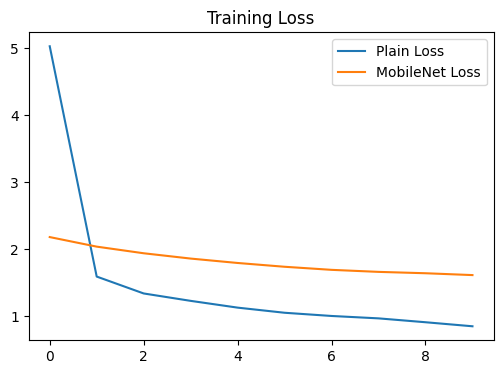

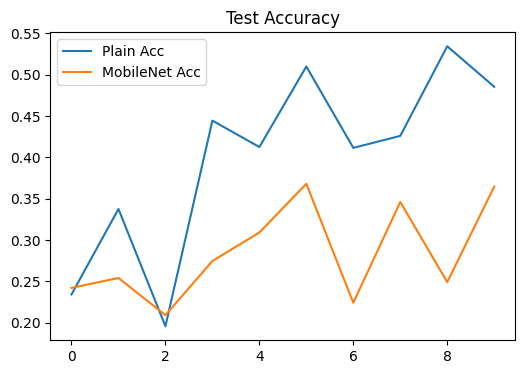

In [40]:
def count_parameters(model):
    total = 0
    for layer in model.parameters():
        # Conv / Linear
        if hasattr(layer, "W") and hasattr(layer, "b"):
            total += np.prod(layer.W.shape) + np.prod(layer.b.shape)
        # BatchNorm
        elif hasattr(layer, "gamma") and hasattr(layer, "beta"):
            total += np.prod(layer.gamma.shape) + np.prod(layer.beta.shape)
        # Ignore activation / pooling / dropout
    return int(total)

def estimate_flops(model, input_shape=(1, 3, 32, 32)):
    flops = 0
    C, H, W = input_shape[1:]
    for layer in model.parameters():
        if hasattr(layer, "W"):
            if layer.W.ndim == 4:  # Conv2D
                out_channels, in_channels, kh, kw = layer.W.shape
                flops += out_channels * in_channels * kh * kw * H * W
            elif layer.W.ndim == 2:  # Linear
                flops += np.prod(layer.W.shape)
    return int(flops)


# Initialize models
plain = PlainCNN()
mobile = MobileNetLite()

opt_plain = SGD(plain.parameters(), lr=0.05, weight_decay=1e-4)
opt_mob   = SGD(mobile.parameters(), lr=0.05, weight_decay=1e-4)

epochs = 10
batch_size = 128
plain_loss, mobile_loss = [], []
plain_acc, mobile_acc = [], []

for ep in range(1, epochs + 1):
    # Train Plain CNN
    Lp, steps = 0, 0
    for Xb, Yb in iterate_minibatches(X_train, Y_train, batch_size=batch_size, shuffle=True):
        logits = plain.forward(Xb, training=True)
        loss = plain.loss(logits, Yb)
        plain.backward(); opt_plain.step()
        Lp += loss; steps += 1
    plain_loss.append(Lp / steps)
    plain_acc.append(accuracy(plain, X_test, y_test))

    # Train MobileNetLite
    Lm, steps = 0, 0
    for Xb, Yb in iterate_minibatches(X_train, Y_train, batch_size=batch_size, shuffle=True):
        logits = mobile.forward(Xb, training=True)
        loss = mobile.loss(logits, Yb)
        mobile.backward(); opt_mob.step()
        Lm += loss; steps += 1
    mobile_loss.append(Lm / steps)
    mobile_acc.append(accuracy(mobile, X_test, y_test))

    print(f"Epoch {ep:02d} | PlainAcc {plain_acc[-1]:.4f} | MobileAcc {mobile_acc[-1]:.4f}")

# Compare parameter and FLOP counts
plain_params  = count_parameters(plain)
mobile_params = count_parameters(mobile)
plain_flops   = estimate_flops(plain)
mobile_flops  = estimate_flops(mobile)

param_reduction = 100 * (1 - mobile_params / plain_params)
acc_drop = 100 * (plain_acc[-1] - mobile_acc[-1]) / plain_acc[-1]

print("\n=== Model Comparison ===")
print(f"PlainCNN  Params : {plain_params:,}")
print(f"MobileNet Params : {mobile_params:,}")
print(f"Parameter reduction: {param_reduction:.2f}%")
print(f"PlainCNN  FLOPs   : {plain_flops:,}")
print(f"MobileNet FLOPs   : {mobile_flops:,}")
print(f"Approx. FLOPs reduction: {100 * (1 - mobile_flops / plain_flops):.2f}%")
print(f"Accuracy drop: {acc_drop:.2f}%")

# Visualization
plt.figure(figsize=(6,4))
plt.plot(plain_loss, label='Plain Loss')
plt.plot(mobile_loss, label='MobileNet Loss')
plt.legend(); plt.title('Training Loss'); plt.show()

plt.figure(figsize=(6,4))
plt.plot(plain_acc, label='Plain Acc')
plt.plot(mobile_acc, label='MobileNet Acc')
plt.legend(); plt.title('Test Accuracy'); plt.show()


### Question

**1. (1 point)**  
What is the main difference between convolutional layers and fully connected layers in how they handle spatial information?

**Answer:**  

Convolutional layers keep spatial structure via **local connectivity + weight sharing**, producing translation-equivariant feature maps with far fewer parameters. Fully connected layers first **flatten** the image, losing spatial locality and treating every pixel position independently.

---

**2. (1 point)**  
Explain how the receptive field grows as we stack more convolutional and pooling layers.  
Why is this important for feature learning?

**Answer:**  

Each layer enlarges the receptive field: for layer (l) with kernel (k_l) and stride (s_l),
$
R_l = R_{l-1} + (k_l - 1)\prod_{j<l} s_j ,
$
so pooling/strided convs (larger (s)) make it grow faster. A larger receptive field lets deeper units integrate **wider context**—early layers learn edges/textures, mid layers parts, and deep layers whole objects/relations—crucial for tasks needing global information.

---

**3. (1 point)**  
Even with ReLU activation, why can deep CNNs still suffer from vanishing gradients, and how does ResNet address this issue?

**Answer:**  

Long chains of linear/BN/ReLU layers can still make backpropagated gradients **shrink** (or explode) due to repeated multiplication by Jacobians with norms < 1 and dead ReLUs. ResNet adds **identity skip connections**, computing $y = F(x)+x$. During backprop, $\frac{\partial \mathcal{L}}{\partial x} = \frac{\partial \mathcal{L}}{\partial y}(I + \frac{\partial F}{\partial x})$, giving a **direct gradient path** (the (I) term) that preserves signal and stabilizes very deep networks.

---

**4. (1 point)**  
Depthwise convolution computes each channel separately.  
What limitation does this cause, and how does the pointwise convolution fix it?

**Answer:**  

Depthwise conv **doesn’t mix information across channels**, so it cannot create new inter-channel features. A **pointwise (1×1) convolution** mixes channels at each spatial location (learns linear combinations), restoring cross-channel interactions and expressiveness when paired with depthwise conv (i.e., depthwise-separable convolution).


---


# **Question 4 — Recurrent Neural Networks (RNNs)**

In previous questions, you have implemented deep learning models **entirely from scratch** (e.g., CNNs, ResNet, and MobileNet) to understand the core mechanics of forward and backward propagation.

Starting from this question, we will move to **more advanced architectures** and use **PyTorch** — a modern deep learning framework — to focus on **model design, sequence modeling, and training stability** rather than low-level gradient computations.

You will explore recurrent models including **RNN**, **LSTM**, and **GRU**, and examine how they handle **short-term vs. long-term dependencies** in sequential data.

**Grading:** This question is worth **15 points total**.


## **Part A — Vanilla RNN on Row-wise MNIST**

Implement a simple **RNN** classifier in **PyTorch** and train it on **Row-wise MNIST**.

Each image (28×28) is treated as a sequence of **28 time steps**, each step being a row of **28** pixels.

**Scoring (6pts)**
- Correct RNN implementation and training loop.
- Achieve **≥ 97%** test accuracy on Row-wise MNIST.
- Provide a short failure test on **Sequential CIFAR-10 (Row-wise)** using the *same* RNN to show its limitation.


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.39MB/s]
100%|██████████| 170M/170M [00:04<00:00, 35.2MB/s]


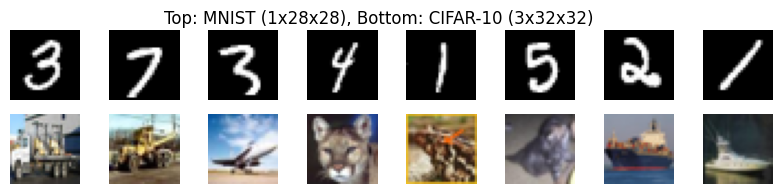

In [41]:
# ⚠️ Do not modify this cell
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(2025)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Datasets
tf_img = transforms.ToTensor()
mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=tf_img)
mnist_test  = datasets.MNIST(root="./data", train=False, download=True, transform=tf_img)
cifar_train = datasets.CIFAR10(root="./data", train=True, download=True, transform=tf_img)
cifar_test  = datasets.CIFAR10(root="./data", train=False, download=True, transform=tf_img)

train_loader_mnist = DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=2)
test_loader_mnist  = DataLoader(mnist_test,  batch_size=256, shuffle=False, num_workers=2)
train_loader_cifar = DataLoader(cifar_train, batch_size=128, shuffle=True, num_workers=2)
test_loader_cifar  = DataLoader(cifar_test,  batch_size=256, shuffle=False, num_workers=2)


def to_sequence(x, mode: str):
    """
    Convert images to (N, T, F).
    mode='rowwise': treat each row as a timestep -> (N, H, C*W)
    mode='pixelwise': treat each pixel as a timestep -> (N, H*W*C, 1)
    """
    if mode == "rowwise":
        x = x.permute(0, 2, 1, 3).reshape(x.size(0), x.size(2), -1)
    elif mode == "pixelwise":
        x = x.view(x.size(0), -1, 1)
    else:
        raise ValueError(f"Unknown mode: {mode}")
    return x



imgs_m, labels_m = next(iter(train_loader_mnist))
imgs_c, labels_c = next(iter(train_loader_cifar))
plt.figure(figsize=(10,2))
for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow(imgs_m[i,0].numpy(), cmap="gray")
    plt.axis("off")
    plt.subplot(2,8,8+i+1)
    plt.imshow(np.transpose(imgs_c[i].numpy(), (1,2,0)))
    plt.axis("off")
plt.suptitle("Top: MNIST (1x28x28), Bottom: CIFAR-10 (3x32x32)")
plt.show()


In [42]:
# Part A — Training & Evaluation (Row-wise MNIST)

class RNNClassifier(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 128, num_classes: int = 10):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, nonlinearity='tanh')
        self.fc  = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # TODO: x is (N, T, F); run RNN and map last hidden to logits
        # Hint: rnn returns (out, h_n) with h_n shape (1, N, H)
        # x: (N, T, F)
        out, h_n = self.rnn(x)           # h_n: (num_layers=1, N, H)
        h_last = h_n[-1]                  # (N, H)
        logits = self.fc(h_last)          # (N, C)
        return logits


rnn = RNNClassifier(input_size=28, hidden_size=128, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn.parameters(), lr=1e-3)

epochs = 15
for ep in range(1, epochs + 1):
    rnn.train()
    total_loss = 0.0

    for X, y in train_loader_mnist:
        # TODO: move data to device
        X, y = X.to(device), y.to(device)

        # sequence view: (N, T=28, F=28)
        X = to_sequence(X, mode="rowwise")

        # TODO: zero out previous gradients
        optimizer.zero_grad()

        # TODO: forward pass
        logits = rnn(X)

        # TODO: compute loss
        loss = criterion(logits, y)

        # TODO: backward pass
        loss.backward()

        # TODO: gradient clipping to prevent exploding gradients
        # Hint: use torch.nn.utils.clip_grad_norm_
        torch.nn.utils.clip_grad_norm_(rnn.parameters(), max_norm=5.0)

        # TODO: update parameters
        optimizer.step()

        total_loss += loss.item()

    print(f"[A] Epoch {ep:02d} | RNN Loss {total_loss / len(train_loader_mnist):.4f}")





[A] Epoch 01 | RNN Loss 0.9585
[A] Epoch 02 | RNN Loss 0.4584
[A] Epoch 03 | RNN Loss 0.2966
[A] Epoch 04 | RNN Loss 0.2220
[A] Epoch 05 | RNN Loss 0.1854
[A] Epoch 06 | RNN Loss 0.1713
[A] Epoch 07 | RNN Loss 0.1494
[A] Epoch 08 | RNN Loss 0.1420
[A] Epoch 09 | RNN Loss 0.1338
[A] Epoch 10 | RNN Loss 0.1197
[A] Epoch 11 | RNN Loss 0.1143
[A] Epoch 12 | RNN Loss 0.1102
[A] Epoch 13 | RNN Loss 0.1033
[A] Epoch 14 | RNN Loss 0.0980
[A] Epoch 15 | RNN Loss 0.0914


⚠️ **Do not modify this cell** — any changes will result in a score of **0** for Part A.

In [43]:
def evaluate(model, loader, seq_mode: str):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            X = to_sequence(X, seq_mode)
            logits = model(X)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total


acc_rnn_mnist = evaluate(rnn, test_loader_mnist, seq_mode="rowwise")
print(f"[A] RNN Test Acc (Row-wise MNIST): {acc_rnn_mnist:.4f}")

[A] RNN Test Acc (Row-wise MNIST): 0.9703


### **Failure case — RNN on Sequential CIFAR-10 (Row-wise)**

Now, reuse your trained RNN implementation from above,  
but train it on **Sequential CIFAR-10 (Row-wise)** instead of MNIST.

Each 32×32×3 image is reshaped into a sequence of **32 time steps**,  
where each step corresponds to one RGB row (3×32 = 96 features).  
This setting is much harder than MNIST, due to the **longer sequences** and **high-dimensional inputs**.

⚠️ You should observe that even after training, accuracy remains low.  
This demonstrates that **vanilla RNNs struggle with long-term dependencies** and  
suffer from **vanishing/exploding gradients** when sequences are long.


In [44]:
# Part A — Failure Case: RNN on Row-wise CIFAR-10
# Expectation: accuracy degrades on longer, higher-dim sequences.

rnn_fail = RNNClassifier(input_size=96, hidden_size=128, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_fail.parameters(), lr=1e-3)

epochs = 15
for ep in range(1, epochs+1):
    rnn_fail.train()
    total = 0.0
    for X, y in train_loader_cifar:

        # TODO:
        # Copy your training loop from Part A (RNN on MNIST)
        # and modify it so that it uses:
        #   - rnn_fail instead of rnn
        # Keep all other steps the same (forward, backward, optimizer, etc.)
        X, y = X.to(device), y.to(device)
        X = to_sequence(X, mode="rowwise")       # (N, T=32, F=96)

        optimizer.zero_grad()
        logits = rnn_fail(X)
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(rnn_fail.parameters(), max_norm=5.0)
        optimizer.step()

        total += loss.item()
    print(f"[A:Fail] Epoch {ep:02d} | RNN-CIFAR Loss {total/len(train_loader_cifar):.4f}")

acc_rnn_cifar = evaluate(rnn_fail, test_loader_cifar, seq_mode="rowwise")
print(f"[A:Fail] RNN Test Acc (Row-wise CIFAR-10): {acc_rnn_cifar:.4f}")
print(f"Δ vs Part A (MNIST row-wise): {acc_rnn_cifar - acc_rnn_mnist:+.4f}  (expected drop)")


[A:Fail] Epoch 01 | RNN-CIFAR Loss 2.0526
[A:Fail] Epoch 02 | RNN-CIFAR Loss 1.9196
[A:Fail] Epoch 03 | RNN-CIFAR Loss 1.8816
[A:Fail] Epoch 04 | RNN-CIFAR Loss 1.7994
[A:Fail] Epoch 05 | RNN-CIFAR Loss 1.7931
[A:Fail] Epoch 06 | RNN-CIFAR Loss 1.7256
[A:Fail] Epoch 07 | RNN-CIFAR Loss 1.7049
[A:Fail] Epoch 08 | RNN-CIFAR Loss 1.6842
[A:Fail] Epoch 09 | RNN-CIFAR Loss 1.6598
[A:Fail] Epoch 10 | RNN-CIFAR Loss 1.6382
[A:Fail] Epoch 11 | RNN-CIFAR Loss 1.6447
[A:Fail] Epoch 12 | RNN-CIFAR Loss 1.6259
[A:Fail] Epoch 13 | RNN-CIFAR Loss 1.6091
[A:Fail] Epoch 14 | RNN-CIFAR Loss 1.6069
[A:Fail] Epoch 15 | RNN-CIFAR Loss 1.6157
[A:Fail] RNN Test Acc (Row-wise CIFAR-10): 0.4141
Δ vs Part A (MNIST row-wise): -0.5562  (expected drop)


## **Part B — LSTM on Sequential CIFAR-10 (Row-wise)**

Replace the vanilla RNN with an **LSTM** and train it on **Sequential CIFAR-10 (Row-wise)**.

Each 32 × 32 × 3 image is reshaped into a sequence of **32 time steps**,  
each step containing **96 features (3 × 32)**.  
LSTMs use gating mechanisms to **preserve and forget information** selectively,  
allowing them to capture longer-range dependencies that a vanilla RNN cannot.

**Scoring (3pts)**  
- Correct PyTorch implementation of the LSTM training loop.  
- Achieve **higher test accuracy than your RNN baseline** on Sequential CIFAR-10.  
- Provide a short failure test on **Sequential MNIST (Pixel-wise)** using the *same* RNN to show its limitation.


CIFAR row-wise sequence: torch.Size([128, 32, 96])  (N, T=32, F=96)
MNIST pixel-wise sequence: torch.Size([128, 784, 1])  (N, T=784, F=1)


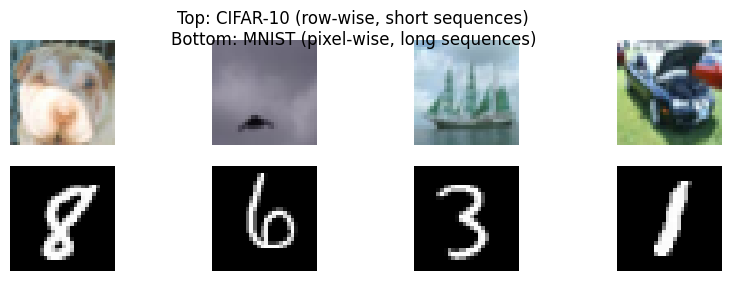

In [45]:
# Setup B — visualize both CIFAR (row-wise) and MNIST (pixel-wise)
# Reuse to_sequence() and evaluate() from Part A

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt, numpy as np

tf_img = transforms.ToTensor()

# CIFAR-10 for main LSTM task
cifar_train = datasets.CIFAR10(root="./data", train=True, download=True, transform=tf_img)
cifar_test  = datasets.CIFAR10(root="./data", train=False, download=True, transform=tf_img)
train_loader_cifar = DataLoader(cifar_train, batch_size=128, shuffle=True, num_workers=2)
test_loader_cifar  = DataLoader(cifar_test,  batch_size=256, shuffle=False, num_workers=2)

# MNIST for failure case (very long pixel-wise sequences)
mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=tf_img)
mnist_test  = datasets.MNIST(root="./data", train=False, download=True, transform=tf_img)
train_loader_mnist = DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=2)
test_loader_mnist  = DataLoader(mnist_test,  batch_size=256, shuffle=False, num_workers=2)

imgs_c, _ = next(iter(train_loader_cifar))
seq_c = to_sequence(imgs_c, "rowwise")
print(f"CIFAR row-wise sequence: {seq_c.shape}  (N, T=32, F=96)")

imgs_m, _ = next(iter(train_loader_mnist))
seq_m = to_sequence(imgs_m, "pixelwise")
print(f"MNIST pixel-wise sequence: {seq_m.shape}  (N, T=784, F=1)")

plt.figure(figsize=(10,3))
for i in range(4):
    plt.subplot(2,4,i+1)
    plt.imshow(np.transpose(imgs_c[i].numpy(), (1,2,0)))
    plt.axis("off")
for i in range(4):
    plt.subplot(2,4,4+i+1)
    plt.imshow(imgs_m[i,0].numpy(), cmap="gray")
    plt.axis("off")
plt.suptitle("Top: CIFAR-10 (row-wise, short sequences)\nBottom: MNIST (pixel-wise, long sequences)")
plt.show()


In [46]:
# Part B — LSTM on Sequential CIFAR-10 (Row-wise)

class LSTMClassifier(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 128, num_classes: int = 10):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc   = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # TODO: x is (N, T, F); run LSTM and map last hidden to logits
        # Hint: lstm returns (out, (h, c)); use h[-1]
        out, (h, c) = self.lstm(x)   # h: (num_layers, N, H)
        h_last = h[-1]               # (N, H)
        logits = self.fc(h_last)     # (N, C)
        return logits


lstm = LSTMClassifier(input_size=96, hidden_size=128, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm.parameters(), lr=1e-3)

epochs = 15
for ep in range(1, epochs+1):
    lstm.train()
    total = 0.0
    for X, y in train_loader_cifar:
        # TODO:
        # Copy your training loop from Part A (RNN on MNIST)
        # and modify it so that it uses:
        #   - lstm instead of rnn
        # Keep all other steps the same (forward, backward, optimizer, etc.)
        X, y = X.to(device), y.to(device)
        X = to_sequence(X, mode="rowwise")   # (N, 32, 96)

        optimizer.zero_grad()
        logits = lstm(X)
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(lstm.parameters(), max_norm=5.0)
        optimizer.step()

        total += loss.item()
    print(f"[B] Epoch {ep:02d} | LSTM-CIFAR Loss {total/len(train_loader_cifar):.4f}")



[B] Epoch 01 | LSTM-CIFAR Loss 1.8999
[B] Epoch 02 | LSTM-CIFAR Loss 1.6604
[B] Epoch 03 | LSTM-CIFAR Loss 1.5393
[B] Epoch 04 | LSTM-CIFAR Loss 1.4545
[B] Epoch 05 | LSTM-CIFAR Loss 1.3826
[B] Epoch 06 | LSTM-CIFAR Loss 1.3328
[B] Epoch 07 | LSTM-CIFAR Loss 1.2781
[B] Epoch 08 | LSTM-CIFAR Loss 1.2380
[B] Epoch 09 | LSTM-CIFAR Loss 1.1949
[B] Epoch 10 | LSTM-CIFAR Loss 1.1586
[B] Epoch 11 | LSTM-CIFAR Loss 1.1316
[B] Epoch 12 | LSTM-CIFAR Loss 1.1048
[B] Epoch 13 | LSTM-CIFAR Loss 1.0749
[B] Epoch 14 | LSTM-CIFAR Loss 1.0454
[B] Epoch 15 | LSTM-CIFAR Loss 1.0243


⚠️ **Do not modify this cell** — any changes will result in a score of **0** for Part B.

In [47]:
acc_lstm_cifar = evaluate(lstm, test_loader_cifar, seq_mode="rowwise")
print(f"[B] LSTM Test Acc (Row-wise CIFAR-10): {acc_lstm_cifar:.4f}")
print(f"Δ vs Part A (RNN on CIFAR): {acc_lstm_cifar - acc_rnn_cifar:+.4f}  (expected improvement)")


[B] LSTM Test Acc (Row-wise CIFAR-10): 0.5825
Δ vs Part A (RNN on CIFAR): +0.1684  (expected improvement)


### **Failure case — LSTM on Sequential MNIST (Pixel-wise)**

Finally, reuse your LSTM model for **Sequential MNIST (Pixel-wise)**,  
where each 28 × 28 image is flattened into 784 time steps with 1 feature per step.  

⚠️ Even though LSTMs are more powerful than RNNs, they still struggle on very long,  
low-information sequences due to gradient decay over hundreds of steps.  
Accuracy should hover around random guess (~10 %).  


In [48]:
# Part B — Failure Case: LSTM on Pixel-wise MNIST (784 steps x 1 feat)
# Expectation: performance degrades due to extremely long sequences.

lstm_fail = LSTMClassifier(input_size=1, hidden_size=128, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_fail.parameters(), lr=1e-3)

epochs = 15
for ep in range(1, epochs+1):
    lstm_fail.train()
    total = 0.0
    for X, y in train_loader_mnist:


        # TODO:
        # Copy your training loop from Part B
        # and modify it so that it uses:
        #   - lstm_fail instead of lstm
        #   - to_sequence(X, mode="pixelwise") for Pixel-wise MNIST
        # Keep all other steps the same (forward, backward, optimizer, etc.)
        X, y = X.to(device), y.to(device)
        X = to_sequence(X, mode="pixelwise")   # (N, 784, 1)

        optimizer.zero_grad()
        logits = lstm_fail(X)
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(lstm_fail.parameters(), max_norm=5.0)
        optimizer.step()

        total += loss.item()
    print(f"[B:Fail] Epoch {ep:02d} | LSTM-MNIST(px) Loss {total/len(train_loader_mnist):.4f}")

acc_lstm_px = evaluate(lstm_fail, test_loader_mnist, seq_mode="pixelwise")
print(f"[B:Fail] LSTM Test Acc (Pixel-wise MNIST): {acc_lstm_px:.4f}")
print(f"Δ vs Part B (LSTM on CIFAR row-wise): {acc_lstm_px - acc_lstm_cifar:+.4f}  (expected drop)")


[B:Fail] Epoch 01 | LSTM-MNIST(px) Loss 2.3018
[B:Fail] Epoch 02 | LSTM-MNIST(px) Loss 2.3016
[B:Fail] Epoch 03 | LSTM-MNIST(px) Loss 2.3013
[B:Fail] Epoch 04 | LSTM-MNIST(px) Loss 2.2112
[B:Fail] Epoch 05 | LSTM-MNIST(px) Loss 2.2570
[B:Fail] Epoch 06 | LSTM-MNIST(px) Loss 2.2980
[B:Fail] Epoch 07 | LSTM-MNIST(px) Loss 2.2877
[B:Fail] Epoch 08 | LSTM-MNIST(px) Loss 2.2855
[B:Fail] Epoch 09 | LSTM-MNIST(px) Loss 2.2845
[B:Fail] Epoch 10 | LSTM-MNIST(px) Loss 2.2643
[B:Fail] Epoch 11 | LSTM-MNIST(px) Loss 2.1090
[B:Fail] Epoch 12 | LSTM-MNIST(px) Loss 2.0448
[B:Fail] Epoch 13 | LSTM-MNIST(px) Loss 2.0489
[B:Fail] Epoch 14 | LSTM-MNIST(px) Loss 1.9386
[B:Fail] Epoch 15 | LSTM-MNIST(px) Loss 1.8952
[B:Fail] LSTM Test Acc (Pixel-wise MNIST): 0.2909
Δ vs Part B (LSTM on CIFAR row-wise): -0.2916  (expected drop)


## **Part C — GRU + Gradient Clipping on Sequential MNIST (Pixel-wise)**

In this part, you will replace the LSTM with a **GRU (Gated Recurrent Unit)** and  
apply **gradient clipping** to stabilize training on very long sequences.

You will reuse the **Sequential MNIST (Pixel-wise)** task from Part B,  
where each 28 × 28 image becomes 784 steps of 1 feature each.

GRUs are a simplified version of LSTMs that merge the forget and input gates,  
making them computationally lighter and sometimes easier to train.

**Scoring (2pts)**
- Correct PyTorch implementation of **GRU + gradient clipping** in the training loop.  
- GRU achieves **significantly higher accuracy** than your Part B LSTM on pixel-wise MNIST.  


MNIST pixel-wise shape: torch.Size([128, 784, 1]) (N, seq_len=784, feat_dim=1)


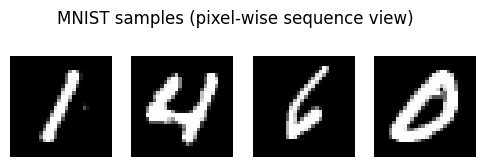

In [49]:
# Setup C — Pixel-wise MNIST for GRU task
# We reuse to_sequence() and evaluate() from previous parts

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

tf_img = transforms.ToTensor()
mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=tf_img)
mnist_test  = datasets.MNIST(root="./data", train=False, download=True, transform=tf_img)
train_loader_mnist = DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=2)
test_loader_mnist  = DataLoader(mnist_test,  batch_size=256, shuffle=False, num_workers=2)

imgs, _ = next(iter(train_loader_mnist))
seq = to_sequence(imgs, "pixelwise")
print(f"MNIST pixel-wise shape: {seq.shape} (N, seq_len=784, feat_dim=1)")

plt.figure(figsize=(6,2))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(imgs[i,0].numpy(), cmap="gray")
    plt.axis("off")
plt.suptitle("MNIST samples (pixel-wise sequence view)")
plt.show()


In [50]:
# Part C — Implementation

class GRUClassifier(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 128, num_classes: int = 10):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc  = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # TODO: x is (N, T, F); run GRU and map last hidden to logits
        out, h = self.gru(x)          # h: (num_layers, N, H)
        h_last = h[-1]                # (N, H)
        logits = self.fc(h_last)      # (N, C)
        return logits


In [51]:
# Part C — Training & Evaluation (Pixel-wise MNIST) + Compare to LSTM on same task

gru = GRUClassifier(input_size=1, hidden_size=128, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru.parameters(), lr=1e-3)

epochs = 15
for ep in range(1, epochs+1):
    gru.train()
    total = 0.0
    for X, y in train_loader_mnist:
        X, y = X.to(device), y.to(device)
        # TODO:
        # Copy your training loop from Part B
        # and modify it so that it uses:
        #   - gru instead of lstm
        #   - to_sequence(X, mode="pixelwise") for Pixel-wise MNIST
        # Keep all other steps the same (forward, backward, optimizer, etc.)
        X = to_sequence(X, mode="pixelwise")  # (N, 784, 1)

        optimizer.zero_grad()
        logits = gru(X)
        loss = criterion(logits, y)
        loss.backward()

        # stronger clipping is helpful on very long sequences
        torch.nn.utils.clip_grad_norm_(gru.parameters(), max_norm=5.0)

        optimizer.step()

        total += loss.item()
    print(f"[C] Epoch {ep:02d} | GRU-MNIST(px) Loss {total/len(train_loader_mnist):.4f}")




[C] Epoch 01 | GRU-MNIST(px) Loss 2.2948
[C] Epoch 02 | GRU-MNIST(px) Loss 2.0001
[C] Epoch 03 | GRU-MNIST(px) Loss 1.3384
[C] Epoch 04 | GRU-MNIST(px) Loss 0.8840
[C] Epoch 05 | GRU-MNIST(px) Loss 0.5398
[C] Epoch 06 | GRU-MNIST(px) Loss 0.5776
[C] Epoch 07 | GRU-MNIST(px) Loss 0.3427
[C] Epoch 08 | GRU-MNIST(px) Loss 0.3297
[C] Epoch 09 | GRU-MNIST(px) Loss 0.2483
[C] Epoch 10 | GRU-MNIST(px) Loss 0.1971
[C] Epoch 11 | GRU-MNIST(px) Loss 0.1686
[C] Epoch 12 | GRU-MNIST(px) Loss 0.1472
[C] Epoch 13 | GRU-MNIST(px) Loss 0.1281
[C] Epoch 14 | GRU-MNIST(px) Loss 0.1160
[C] Epoch 15 | GRU-MNIST(px) Loss 0.1036


⚠️ **Do not modify this cell** — any changes will result in a score of **0** for Part C.

In [52]:
acc_gru_px = evaluate(gru, test_loader_mnist, seq_mode="pixelwise")
print(f"[C] GRU Test Acc (Pixel-wise MNIST): {acc_gru_px:.4f}")
print(f"Δ vs Part B: LSTM on Pixel-wise MNIST = {acc_gru_px - acc_lstm_px:+.4f}  (expected improvement)")

[C] GRU Test Acc (Pixel-wise MNIST): 0.9669
Δ vs Part B: LSTM on Pixel-wise MNIST = +0.6760  (expected improvement)


### Question

**1. (1 point)**  
Why does a vanilla RNN struggle to learn long-term dependencies?

**Answer:**  Because the gradient from a loss at time (T) back to an event at time (t) is a product of many Jacobians $\prod_{k=t+1}^{T}\partial h_k/\partial h_{k-1}$. With tanh/sigmoid nonlinearities and recurrent weights whose spectral radius < 1, this product decays exponentially (vanishing gradients); if > 1, it explodes. As a result, credit assignment over many time steps becomes unreliable and the model can’t learn long-range effects.

---

**2. (1 point)**  
How do the gating mechanisms in LSTM help prevent vanishing gradients?

**Answer:**  LSTMs create an **additive** memory path (the cell state)
   $
   c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t
   $
   so gradients flow through (c_t) mostly unchanged (“constant error carousel”). The **forget gate** (f_t) can stay near 1 to preserve information/gradients; the **input** and **output** gates control when to write/read, preventing saturation and allowing long-term retention without exponential decay.

---

**3. (1 point)**  
Compared to LSTM, what are the key design differences of GRU, and how do they affect its training efficiency?

**Answer:**  GRUs **merge** cell and hidden state (no separate (c_t)) and use **two gates** (update (z_t) and reset (r_t)) instead of LSTM’s three (input, forget, output). The update rule is
   $
   h_t=(1-z_t)\odot h_{t-1}+z_t\odot \tilde{h}_t.
   $
   Fewer gates/parameters → lighter computation per step, faster training, and often similar accuracy with less data; slightly less expressive than LSTMs on tasks needing very fine-grained memory control.
   
---

**4. (1 point)**  
What is the purpose of gradient clipping, and when is it necessary during training?

**Answer:**  Gradient clipping bounds the gradient norm (or values) before the optimizer step to prevent **exploding gradients**, stabilizing updates. It’s especially necessary for RNNs/LSTMs/GRUs on long sequences, deep networks, or when using larger learning rates where occasional large gradients can destabilize training.

---
